### TASK 1 - Domestic Hydrogen Production

In [1]:
import pandas as pd
import pypsa
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import numpy as np

### (a) Import the necessary packages and load the pre-built PyPSA network from https://tubcloud.tu-berlin.de/s/m73a6SGXEYAsiyY/download/network-assignment-5.nc

In [2]:
fn = "network-assignment-5.nc"
url = "https://tubcloud.tu-berlin.de/s/m73a6SGXEYAsiyY/download/"+fn
urlretrieve(url,fn)

('network-assignment-5.nc', <http.client.HTTPMessage at 0x17b3cd8ef40>)

In [3]:
n = pypsa.Network(fn)

INFO:pypsa.io:Imported network network-assignment-5.nc has buses, carriers, generators, global_constraints, loads, storage_units


In [4]:
n

PyPSA Network
Components:
 - Bus: 1
 - Carrier: 6
 - Generator: 4
 - GlobalConstraint: 1
 - Load: 1
 - StorageUnit: 2
Snapshots: 8760

### (b) This network has some components we no longer want to consider in this task. Therefore, remove the following components:,
• The Generator named “OCGT”.
• The Storage Unit names “hydrogen storage underground”
• The Global Constraint named “CO2Limit”

In [5]:
n.remove('Generator','OCGT')

In [6]:
n.remove('StorageUnit', 'hydrogen storage underground')

In [7]:
n.remove('GlobalConstraint','CO2Limit')

### (c) Add a hydrogen storage systemto the PyPSA networkwhere storage, electrolysis and re-electification can be individually sized by the model. You can follow the tutorial for this: the steps consist of adding a hydrogen bus, a link for the electrolysis, a link for the hydrogen fuel cell, and a store for the hydrogen store.

First adds bus for hydrogen

In [8]:
n.add('Bus',
     'hydrogen')

In [9]:
n.buses

,control,generator,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
Bus,,,,,,,,,,,,
electricity,Slack,OCGT,1.0,,0.0,0.0,AC,,1.0,0.0,inf,
hydrogen,PQ,NaN,1.0,,0.0,0.0,AC,,1.0,0.0,inf,


Adding electrolysis as Link

In [10]:
n.add('Link',
     'electrolysis',
     bus0 = 'electricity',
     bus1 = 'hydrogen',
     carrier = 'electrolysis',
     p_nom_extendable = True,
     efficiency = 0.7,
     capital_cost = 50e3 #€/Mw/a,
     )

In [11]:
n.add('Link',
     'fuel cell',
     bus0 = 'hydrogen',
     bus1 = 'electricity',
     carrier = 'fuel cell',
     p_nom_extendable = True,
     efficiency = 0.5,
     capital_cost = 120e3 #€/Mw/a
     )

In [12]:
n.links.p_nom_opt

Link
electrolysis    0.0
fuel cell       0.0
Name: p_nom_opt, dtype: float64

Adding store

In [13]:
n.add(
    "Store",
    "hydrogen storage",
    bus="hydrogen",
    carrier='hydrogen storage',
    capital_cost=140, # €/MWh/a
    e_nom_extendable=True,
    e_cyclic=True, # cyclic state of charge
)

In [14]:
n.stores

attribute,bus,type,carrier,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,...,e_cyclic_per_period,p_set,q_set,sign,marginal_cost,capital_cost,standing_loss,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
hydrogen storage,hydrogen,,hydrogen storage,0.0,True,0.0,inf,0.0,1.0,0.0,...,True,0.0,0.0,1.0,0.0,140.0,0.0,0,inf,0.0


### (d) Attach a constant hydrogen demand to the hydrogen bus, such that the total annual demand sums up to 333 TWh. How does it relate to the average electricity demand?

In [15]:
Total_annual_demand_sum_up = 333*1e6 # MWh

In [16]:
p_set_hydrogen = Total_annual_demand_sum_up/8760
p_set_hydrogen

38013.69863013698

In [17]:
n.add(
    "Load",
    "hydrogen demand",
    bus="hydrogen",
    carrier="hydrogen",
    p_set=p_set_hydrogen # MW
)

In [18]:
n.loads

,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
demand,electricity,,,0.00000,0.0,-1.0
hydrogen demand,hydrogen,hydrogen,,38013.69863,0.0,-1.0


In [19]:
avg_electricity_demand = n.loads_t.p_set.demand.mean() # Average electricity demand
avg_electricity_demand

54736.99166666667

In [20]:
perc=p_set_hydrogen/avg_electricity_demand*100 # in percentage
print("Hydrogen demand takes upto",round(perc,2),"% of the average electricity demand")

Hydrogen demand takes upto 69.45 % of the average electricity demand


### (e) Solve the model and list the optimised capacities of each system component in GW and the total annual system costs in G€/a.

In [21]:
n.lopf(solver_name = 'gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.49s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-31
Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-09itlzvt.lp
Reading time = 0.46 seconds
obj: 192720 rows, 87608 columns, 381334 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 192720 rows, 87608 columns and 381334 nonzeros
Model fingerprint: 0x5f4bfb7a
Coefficient statistics:
  Matrix range     [1e-04, 6e+00]
  Objective range  [1e-02, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+04, 8e+04]
Presolve removed 91706 rows and 12867 columns
Presolve time: 0.30s
Presolved: 101014 rows, 74741 columns, 276762 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 7
 A

  94   7.66795171e+10  7.66963686e+10  9.99e-05 5.12e-05  5.77e+01    15s
  95   7.66794326e+10  7.66954868e+10  9.12e-05 4.87e-05  5.48e+01    16s
  96   7.66794073e+10  7.66893133e+10  8.94e-05 3.10e-05  3.69e+01    16s
  97   7.66789080e+10  7.66871643e+10  5.42e-05 2.48e-05  2.72e+01    16s
  98   7.66786883e+10  7.66809915e+10  5.45e-05 7.28e-06  8.76e+00    16s
  99   7.66785466e+10  7.66800701e+10  4.39e-05 4.66e-06  5.25e+00    16s
 100   7.66785350e+10  7.66798679e+10  3.56e-05 4.07e-06  4.54e+00    16s
 101   7.66785265e+10  7.66793470e+10  2.65e-05 2.57e-06  2.94e+00    16s
 102   7.66785188e+10  7.66791236e+10  1.46e-05 1.91e-06  2.22e+00    17s
 103   7.66785102e+10  7.66789173e+10  1.00e-05 1.29e-06  1.49e+00    17s
 104   7.66785030e+10  7.66785957e+10  1.41e-05 2.95e-07  3.41e-01    17s
 105   7.66785017e+10  7.66785087e+10  9.47e-07 2.81e-08  4.49e-02    17s
 106   7.66785012e+10  7.66785011e+10  2.58e-07 2.72e-10  3.85e-04    17s
 107   7.66785012e+10  7.66785012e+10 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.67e+10


('ok', 'optimal')

In [22]:
n.objective/1e9 # billion euros per annual

76.67850116198014

In [23]:
n_obj_base = n.objective/1e9

In [24]:
n.statistics()['Optimal Capacity']/1000 # GW, optimised capacities of each system component

             carrier         
Generator    offwind               152.187136
             onwind                 61.799335
             solar                 417.904567
Link         electrolysis          137.850215
             fuel cell              79.320133
Load         -                            NaN
             hydrogen                     NaN
StorageUnit  battery storage        56.688222
Store        hydrogen storage    37270.381297
Name: Optimal Capacity, dtype: float64

In [25]:
n.statistics()

Capacity Factor  Capital Expenditure   
            carrier                                                  
Generator   offwind                  0.346805         2.406440e+10  \
            onwind                   0.178699         5.938044e+09   
            solar                    0.120756         1.943628e+10   
Link        electrolysis             0.445258         6.892511e+09   
            fuel cell                0.062425         9.518416e+09   
Load        -                             NaN                  NaN   
            hydrogen                      NaN                  NaN   
StorageUnit battery storage          0.279698         5.466727e+09   
Store       hydrogen storage         0.471418         5.217853e+09   

                              Curtailment  Installed Capacity   
            carrier                                             
Generator   offwind           2463.509510                 0.0  \
            onwind            1659.785246                 0.0   
            solar              779.711927                 0.0   
Link        electrolysis              NaN                 0.0   
            fuel cell                 NaN                 0.0   
Load        -                         NaN                 NaN   
            hydrogen                  NaN                 NaN   
StorageUnit battery storage      0.000000                 0.0   
Store       hydrogen storage          NaN                 0.0   

                              Operational Expenditure  Optimal Capacity   
            carrier                                                       
Generator   offwind                       1055.585693      1.521871e+05  \
            onwind                       14908.676269      6.179934e+04   
            solar                          504.642994      4.179046e+05   
Link        electrolysis                     0.000000      1.378502e+05   
            fuel cell                        0.000000      7.932013e+04   
Load        -                                     NaN               NaN   
            hydrogen                              NaN               NaN   
StorageUnit battery storage                  0.000000      5.668822e+04   
Store       hydrogen storage                 0.000000      3.727038e+07   

                                   Revenue        Supply    Withdrawal  
            carrier                                                     
Generator   offwind           2.748134e+06  52779.284640      0.000000  
            onwind            6.927676e+05  11043.463903      0.000000  
            solar             2.219258e+06  50464.299425      0.000000  
Link        electrolysis      7.868163e+05  42965.255185 -61378.935979  
            fuel cell         1.086577e+06   2475.778278  -4951.556555  
Load        -                 5.677175e+06      0.000000 -54736.991667  
            hydrogen          3.076078e+06      0.000000 -38013.698630  
StorageUnit battery storage   6.240555e+05   7604.328007  -8251.226607  
Store       hydrogen storage  5.956454e+05  20279.289928 -20279.289928

In [26]:
n.export_to_netcdf('n_base.nc') # saves for next usages

INFO:pypsa.io:Exported network n_base.nc has links, loads, buses, stores, storage_units, generators, carriers


<xarray.Dataset>
Dimensions:                               (snapshots: 8760,
                                           investment_periods: 0, links_i: 2,
                                           links_t_p0_i: 2, links_t_p1_i: 2,
                                           links_t_mu_lower_i: 2,
                                           links_t_mu_upper_i: 2, loads_i: 2,
                                           loads_t_p_set_i: 1, loads_t_p_i: 2,
                                           ...
                                           storage_units_t_p_dispatch_i: 1,
                                           storage_units_t_p_store_i: 1,
                                           storage_units_t_state_of_charge_i: 1,
                                           generators_i: 3,
                                           generators_t_p_max_pu_i: 3,
                                           generators_t_p_i: 3, carriers_i: 6)
Coordinates: (12/25)
  * snapshots                             (snapshots) int64 0 1 2 ... 8758 8759
  * investment_periods                    (investment_periods) float64 
  * links_i                               (links_i) object 'electrolysis' 'fu...
  * links_t_p0_i                          (links_t_p0_i) object 'electrolysis...
  * links_t_p1_i                          (links_t_p1_i) object 'electrolysis...
  * links_t_mu_lower_i                    (links_t_mu_lower_i) object 'electr...
    ...                                    ...
  * storage_units_t_p_store_i             (storage_units_t_p_store_i) object ...
  * storage_units_t_state_of_charge_i     (storage_units_t_state_of_charge_i) object ...
  * generators_i                          (generators_i) object 'onwind' ... ...
  * generators_t_p_max_pu_i               (generators_t_p_max_pu_i) object 'o...
  * generators_t_p_i                      (generators_t_p_i) object 'offwind'...
  * carriers_i                            (carriers_i) object 'onwind' ... 'b...
Data variables: (12/66)
    snapshots_snapshot                    (snapshots) datetime64[ns] 2015-01-...
    snapshots_objective                   (snapshots) float64 1.0 1.0 ... 1.0
    snapshots_generators                  (snapshots) float64 1.0 1.0 ... 1.0
    snapshots_stores                      (snapshots) float64 1.0 1.0 ... 1.0
    investment_periods_objective          (investment_periods) float64 
    investment_periods_years              (investment_periods) float64 
    ...                                    ...
    generators_up_time_before             (generators_i) int64 1 1 1
    generators_down_time_before           (generators_i) int64 0 0 0
    generators_t_p_max_pu                 (snapshots, generators_t_p_max_pu_i) float64 ...
    generators_t_p                        (snapshots, generators_t_p_i) float64 ...
    carriers_color                        (carriers_i) object 'dodgerblue' .....
    carriers_co2_emissions                (carriers_i) float64 0.0 0.0 ... 0.0
Attributes:
    network__cCounter:           192721
    network__multi_invest:       0
    network__xCounter:           87609
    network_name:                
    network_objective:           76678501161.98013
    network_objective_constant:  0.0
    network_pypsa_version:       0.21.3
    network_srid:                4326
    meta:                        {}

### (f) As you know from various previous assignments, there are constraints to how much wind capacity can be built. Therefore, now limit installable potentials for wind to 200 GW for onshore wind and 70 GW for offshore wind and re run the model. Describe what changed:

In [27]:
n_constrains = pypsa.Network('n_base.nc') # calls saved base model and makes changes.

INFO:pypsa.io:Imported network n_base.nc has buses, carriers, generators, links, loads, storage_units, stores


In [28]:
n_constrains.generators.loc['onwind','p_nom_max'] = 200e3

In [29]:
n_constrains.generators.loc['offwind','p_nom_max'] = 70e3

In [30]:
n_constrains.generators.p_nom_max

Generator
onwind     200000.0
offwind     70000.0
solar           inf
Name: p_nom_max, dtype: float64

In [31]:
n_constrains.lopf(solver_name = 'gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-25s0oq0a.lp
Reading time = 0.44 seconds
obj: 192720 rows, 87608 columns, 381334 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 192720 rows, 87608 columns and 381334 nonzeros
Model fingerprint: 0x1fa140aa
Coefficient statistics:
  Matrix range     [1e-04, 6e+00]
  Objective range  [1e-02, 2e+05]
  Bounds range     [7e+04, 2e+05]
  RHS range        [3e+04, 8e+04]
Presolve removed 91706 rows and 12867 columns
Presolve time: 0.28s
Presolved: 101014 rows, 74741 columns, 276762 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 2.371e+05
 Factor NZ  : 1.685e+06 (roughly 80 MB of memory)
 Factor Ops : 2.950

  95   7.80712162e+10  7.80715391e+10  1.00e-03 1.74e-06  3.08e+00    15s
  96   7.80710417e+10  7.80712967e+10  1.83e-04 9.78e-07  1.27e+00    15s
  97   7.80710026e+10  7.80710353e+10  6.01e-05 1.29e-07  1.71e-01    16s
  98   7.80709976e+10  7.80710033e+10  1.97e-05 2.32e-08  3.06e-02    16s
  99   7.80709968e+10  7.80709970e+10  1.18e-05 2.05e-07  1.05e-03    16s
 100   7.80709968e+10  7.80709968e+10  1.08e-06 5.65e-08  6.05e-07    16s
 101   7.80709968e+10  7.80709968e+10  5.54e-08 1.18e-07  2.53e-09    16s

Barrier solved model in 101 iterations and 16.06 seconds (4.12 work units)
Optimal objective 7.80709968e+10

Crossover log...

     798 DPushes remaining with DInf 0.0000000e+00                16s
       0 DPushes remaining with DInf 0.0000000e+00                16s

    6414 PPushes remaining with PInf 0.0000000e+00                16s
       0 PPushes remaining with PInf 0.0000000e+00                17s

  Push phase complete: Pinf 0.0000000e+00, Dinf 1.6561754e-09     17s




INFO:pypsa.linopf:Optimization successful. Objective value: 7.81e+10


('ok', 'optimal')

#### • Are the capacity limits reached for onshore and offshore wind?

From the statistics we can observe that the capacitiy limit reached for both onshore and offshore wind. And the curtailment of offwind largely reflected in onwind and small reflection in electrolysis and hydrogen storage.

In [32]:
# for constrained system
n_constrains.statistics()['Optimal Capacity']/1000 # GW, optimised capacities of each system component

             carrier         
Generator    offwind                70.000000
             onwind                200.000000
             solar                 418.805398
Link         electrolysis          151.934954
             fuel cell              77.454615
Load         -                            NaN
             hydrogen                     NaN
StorageUnit  battery storage        54.713373
Store        hydrogen storage    40600.257393
Name: Optimal Capacity, dtype: float64

In [33]:
# for base system
n.statistics()['Optimal Capacity']/1000 # GW, optimised capacities of each system component

             carrier         
Generator    offwind               152.187136
             onwind                 61.799335
             solar                 417.904567
Link         electrolysis          137.850215
             fuel cell              79.320133
Load         -                            NaN
             hydrogen                     NaN
StorageUnit  battery storage        56.688222
Store        hydrogen storage    37270.381297
Name: Optimal Capacity, dtype: float64

#### • How much more expensive is the system with these constrained wind potentials (in %)?

1.82 % more expensive than previous system

In [34]:
n_constrains.objective/1e9 # billion euros per annum  # system cost with wind capacity limit

78.07099682083181

In [35]:
n_obj_constrains = n_constrains.objective/1e9
increase_in_expense = round((n_obj_constrains-n_obj_base)/n_obj_base*100,2)
increase_in_expense # in percentage(%)
print(increase_in_expense,'% more expensive than previous system')

1.82 % more expensive than previous system


In [36]:
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex(aggregate_time='sum')
    return tsc.droplevel(0).div(1e9) # billion €/a

In [37]:
# base model
system_cost(n) # billion €/a

carrier
electrolysis         6.892511
fuel cell            9.518416
hydrogen storage     5.217853
battery storage      5.466727
offwind             24.073651
onwind               6.068644
solar               19.440699
dtype: float64

In [38]:
# constrained model
system_cost(n_constrains) # billion €/a

carrier
electrolysis         7.596748
fuel cell            9.294554
hydrogen storage     5.684036
battery storage      5.276282
offwind             11.073031
onwind              19.663715
solar               19.482631
dtype: float64

Text(0.5, 1.0, 'Model with on/offwind capacity constrains')

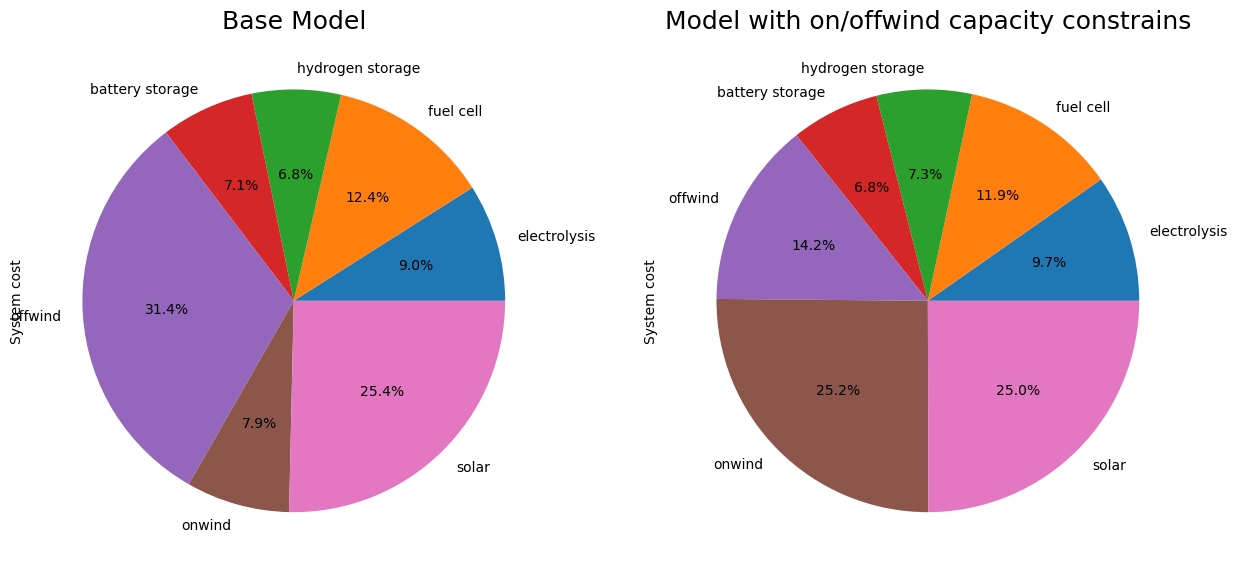

In [39]:
fig,ax = plt.subplots(figsize = (15,7),ncols = 2)
ax0,ax1 = ax
system_cost(n).plot.pie(label = 'System cost',autopct='%1.1f%%',ax = ax0)
ax0.set_title('Base Model',fontsize=18)
system_cost(n_constrains).plot.pie(label = 'System cost',autopct='%1.1f%%',ax = ax1)
ax1.set_title('Model with on/offwind capacity constrains',fontsize=18)

#### • Visualise and describe the differences in capacities built.

The constrains of offwind largely reflected in onwind and small reflection in electrolysis and hydrogen storage. And others  have small change.

In [40]:
# constrained model
n_constrains.statistics()['Optimal Capacity']

             carrier         
Generator    offwind             7.000000e+04
             onwind              2.000000e+05
             solar               4.188054e+05
Link         electrolysis        1.519350e+05
             fuel cell           7.745461e+04
Load         -                            NaN
             hydrogen                     NaN
StorageUnit  battery storage     5.471337e+04
Store        hydrogen storage    4.060026e+07
Name: Optimal Capacity, dtype: float64

Text(0.5, 1.0, 'Model with on/offwind capacity constrains')

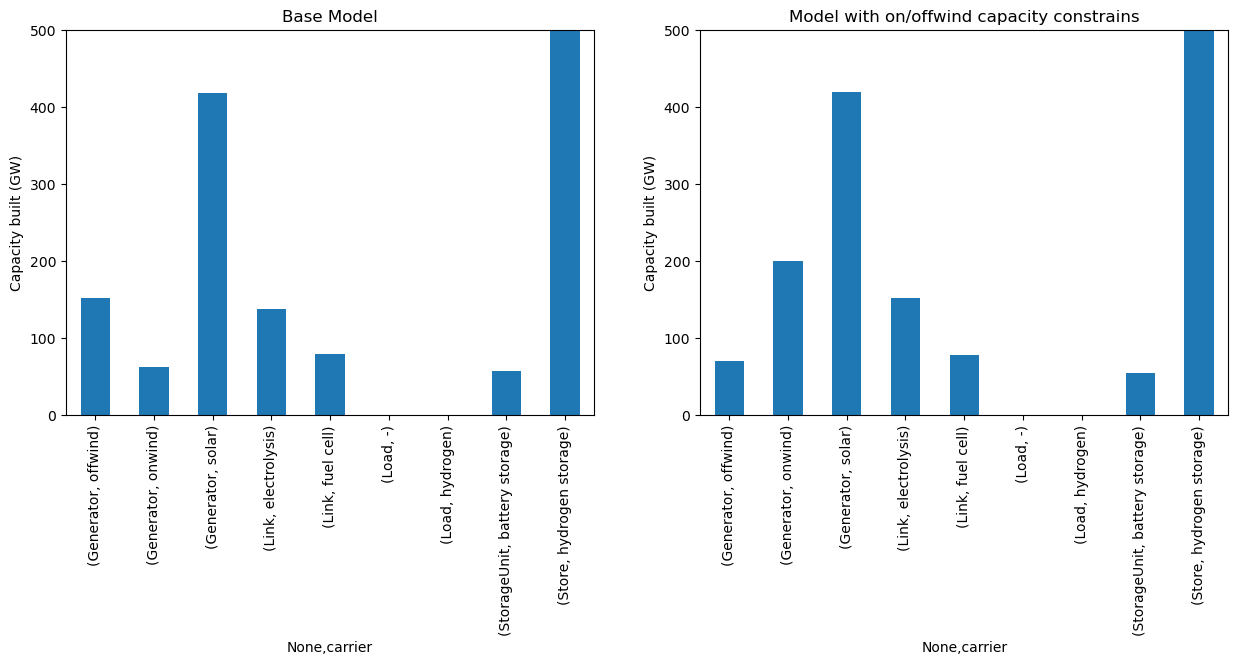

In [41]:
# here provided for better visualisation of capacitis built. Hydrogen capacity is larger compared to others.
# So here we can see the change in capactites built for on/offwind

fig_2,axes_2 = plt.subplots(figsize = (15,5),ncols = 2)
axes2,axes3 = axes_2
axes2.set_ylim(0,500)
axes3.set_ylim(0,500)
n.statistics()['Optimal Capacity'].div(1e3).plot.bar(ax = axes2)
n_constrains.statistics()['Optimal Capacity'].div(1e3).plot.bar(ax = axes3)
axes2.set_ylabel('Capacity built (GW)')
axes3.set_ylabel('Capacity built (GW)')
axes2.set_title('Base Model')
axes3.set_title('Model with on/offwind capacity constrains')

Text(0.5, 1.0, 'Model with on/offwind capacity constrains')

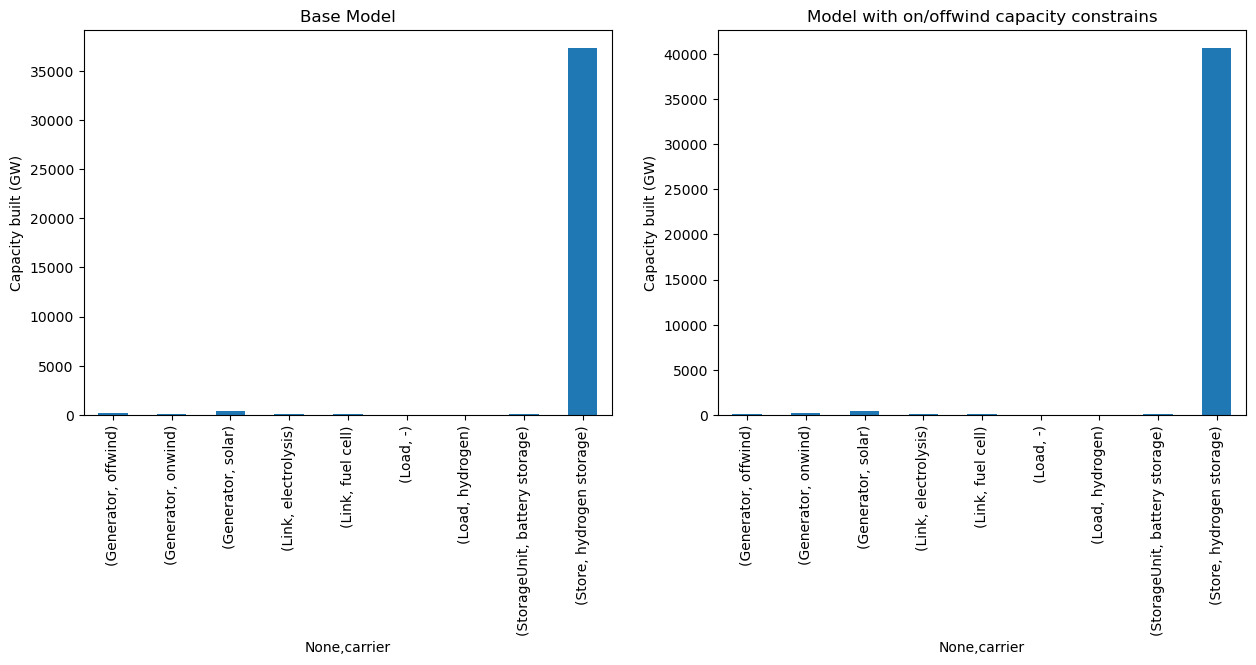

In [42]:
fig_2,axes_2 = plt.subplots(figsize = (15,5),ncols = 2)
axes2,axes3 = axes_2
#axes2.set_ylim(0,500)
#axes3.set_ylim(0,500)
n.statistics()['Optimal Capacity'].div(1e3).plot.bar(ax = axes2)
n_constrains.statistics()['Optimal Capacity'].div(1e3).plot.bar(ax = axes3)
axes2.set_ylabel('Capacity built (GW)')
axes3.set_ylabel('Capacity built (GW)')
axes2.set_title('Base Model')
axes3.set_title('Model with on/offwind capacity constrains')

Text(0.5, 1.0, 'Base Model')

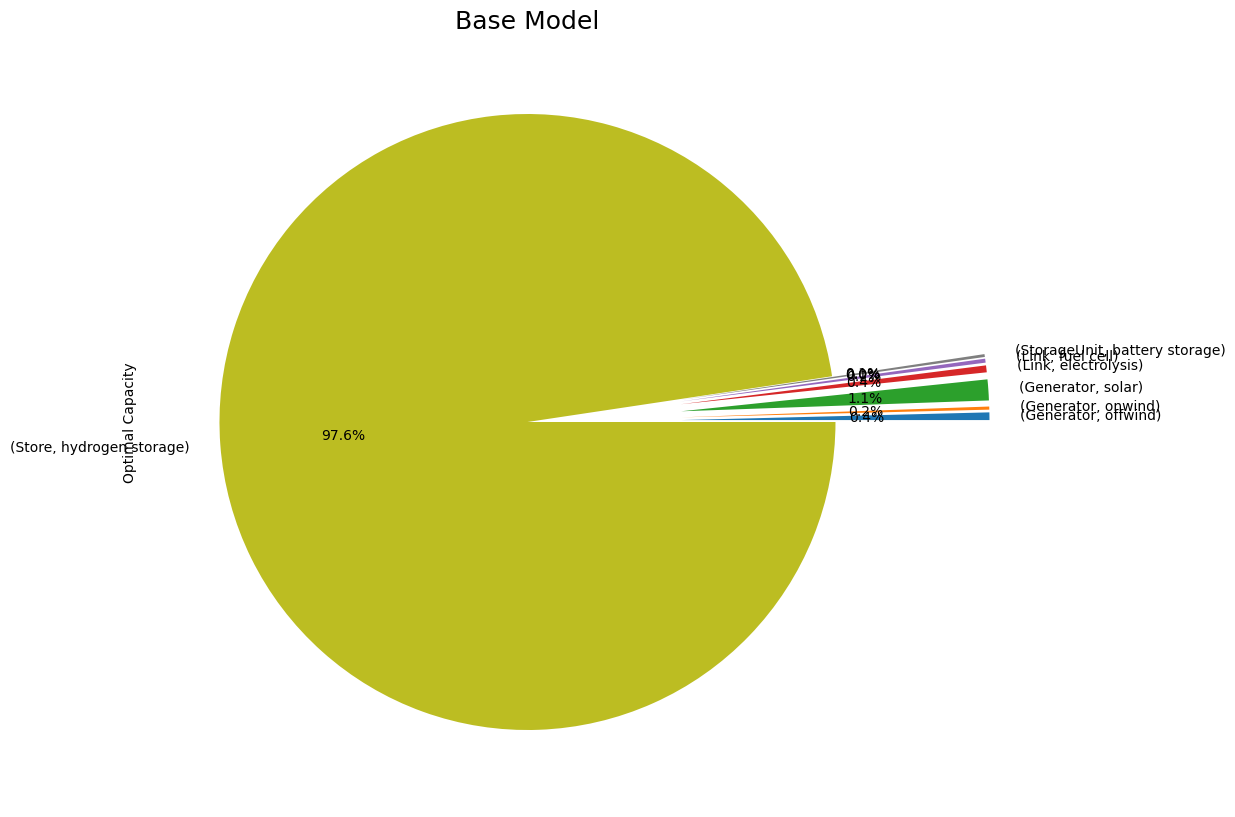

In [43]:
n.statistics()['Optimal Capacity'].div(1e3).plot.pie(figsize =(15,10),autopct='%1.1f%%',explode =[0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0])
plt.title("Base Model",fontsize=18)

Text(0.5, 1.0, 'Model with on/offwind capacity constrains')

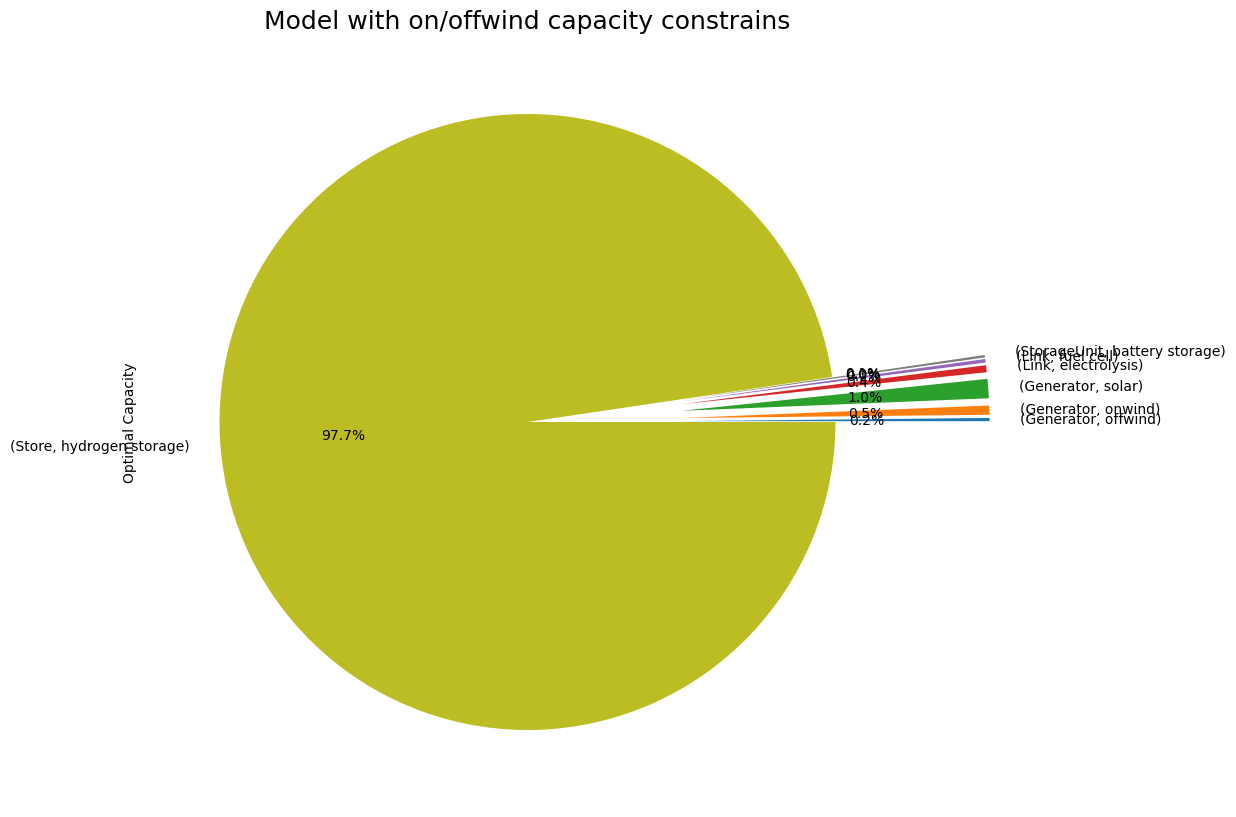

In [44]:
n_constrains.statistics()['Optimal Capacity'].div(1e3).plot.pie(figsize =(15,10),autopct='%1.1f%%',explode =[0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0])
plt.title('Model with on/offwind capacity constrains',fontsize=18)

### (g) Plot the state of charge of the hydrogen store for the full year in units of TWh and of the battery storage for the month of July in units of GWh.

Text(0, 0.5, 'MW')

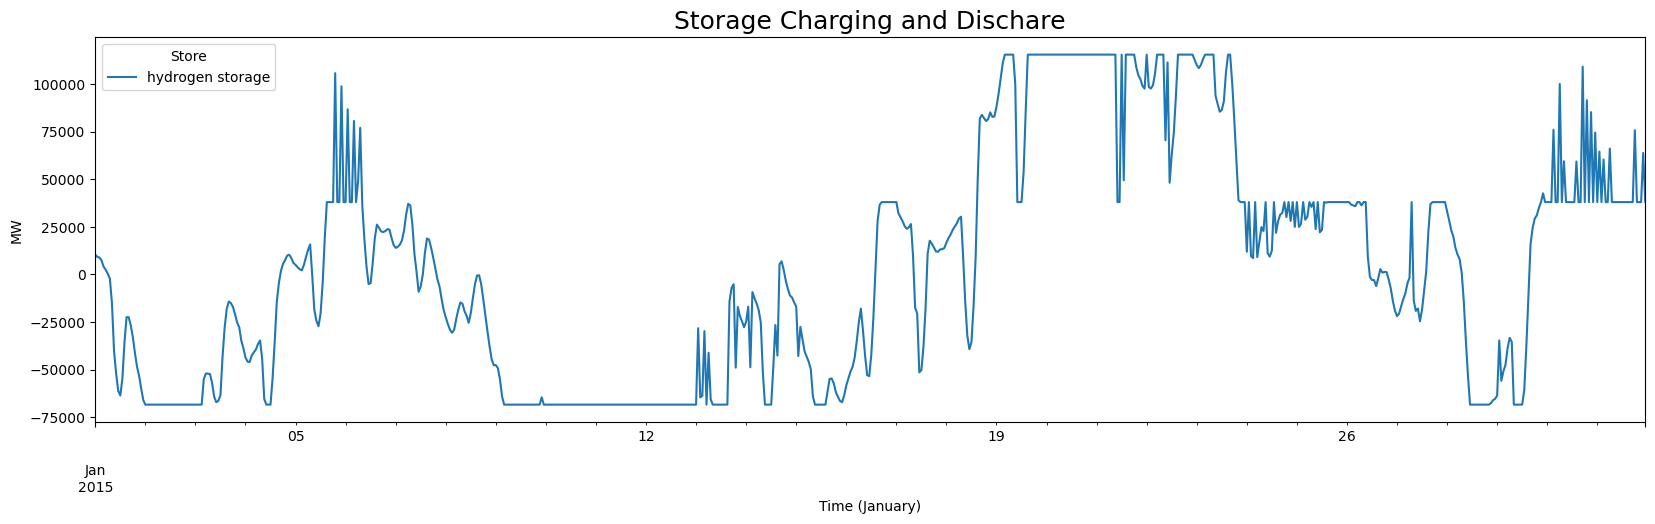

In [45]:
(n_constrains.stores_t.p*1).loc[n_constrains.stores_t.p.index.month==1].plot(figsize = (20,5)) # negative means charging and positive means discharging
plt.title('Storage Charging and Dischare',fontsize = 18)
plt.xlabel('Time (January)')
plt.ylabel('MW')

Text(0, 0.5, 'MW')

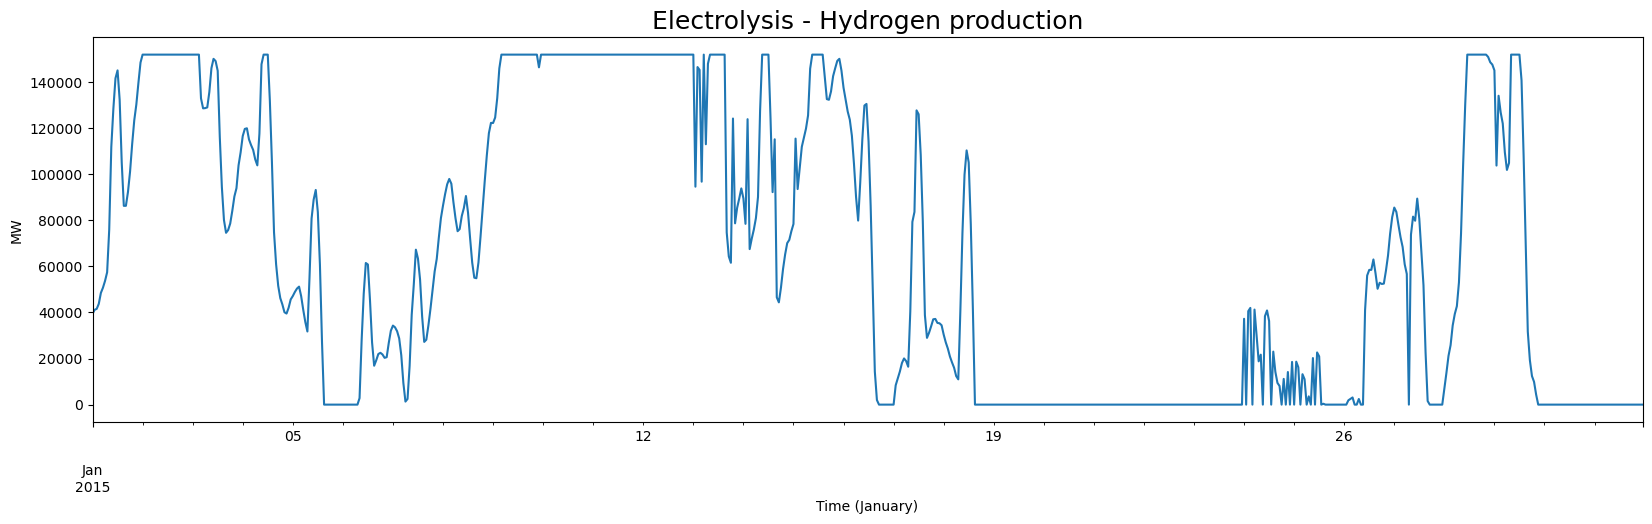

In [46]:
(n_constrains.links_t.p0['electrolysis']).loc[n_constrains.links_t.p0['electrolysis'].index.month==1].plot(figsize = (20,5))
plt.title('Electrolysis - Hydrogen production',fontsize = 18)
plt.xlabel('Time (January)')
plt.ylabel('MW')

Text(0, 0.5, 'MW')

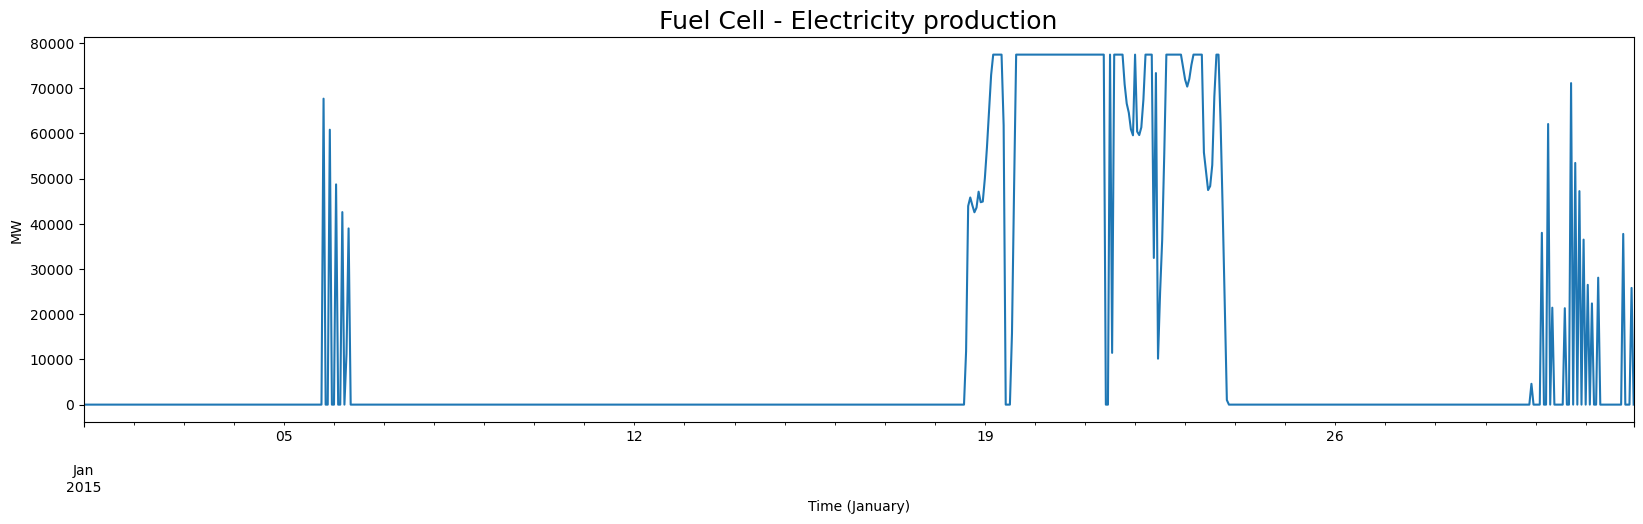

In [47]:
(n_constrains.links_t.p0['fuel cell']).loc[n_constrains.links_t.p0['fuel cell'].index.month==1].plot(figsize = (20,5))
plt.title('Fuel Cell - Electricity production',fontsize = 18)
plt.xlabel('Time (January)')
plt.ylabel('MW')

Text(0.5, 1.0, 'Generation and demand')

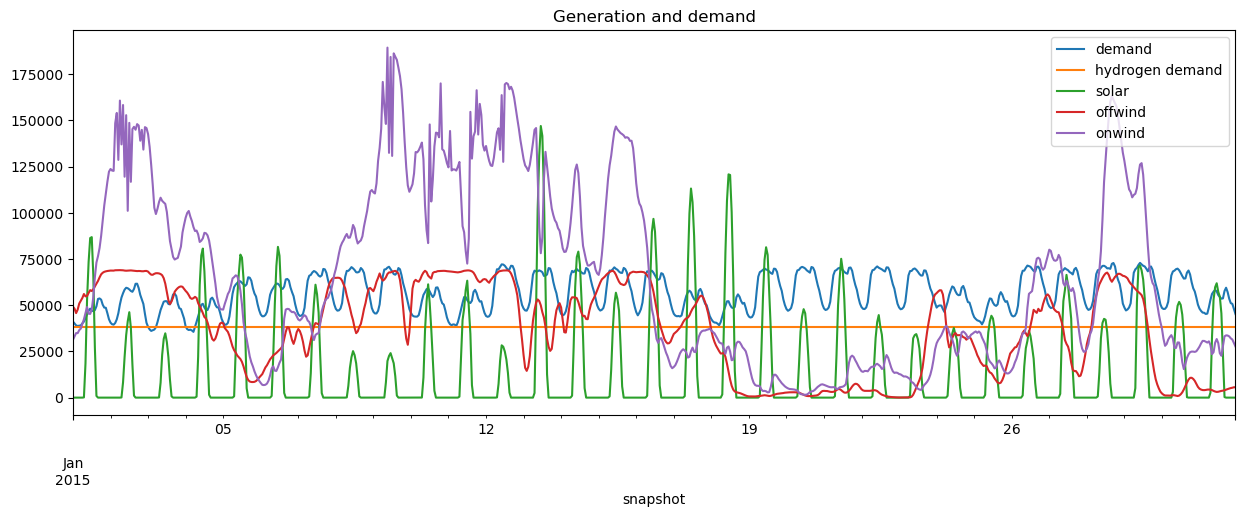

In [48]:
(n_constrains.loads_t.p.loc[n_constrains.loads_t.p.index.month==1]).plot(figsize =(15,5))
(n_constrains.generators_t.p.solar).loc[n_constrains.generators_t.p.solar.index.month==1].plot(figsize=(15,5))
(n_constrains.generators_t.p.offwind).loc[n_constrains.generators_t.p.offwind.index.month==1].plot(figsize=(15,5))
(n_constrains.generators_t.p.onwind).loc[n_constrains.generators_t.p.onwind.index.month==1].plot(figsize=(15,5))
plt.legend()
plt.title('Generation and demand')

#### So from the above plots we can see that, when there is excess renewable, electrolysis works and stores hzdrogen and meets the demand of hydrogen. And when there is no enough renewable generation fuel cell works and provides the electricity back. So during January 7 to 19 we can see excess electricity generation. And in the same duration we can see the amount of hydrogen produced by electrolysis and also the hydrogen stored (In above graph -ve values shows the charging).

n_constrains.stores_t.e.plot(figsize =(15,5))

((n_constrains.links_t.p1*-1)['fuel cell']).loc[(n_constrains.links_t.p1*-1)['fuel cell'].index.month == 1].plot(figsize = (15,5))

n_constrains.links

n_constrains.loads_t.p

n_constrains.generators_t.p.offwind+n_constrains.generators_t.p.onwind+n_constrains.generators_t.p.solar

Text(0.5, 1.0, 'State of Charge Hydrogen full year')

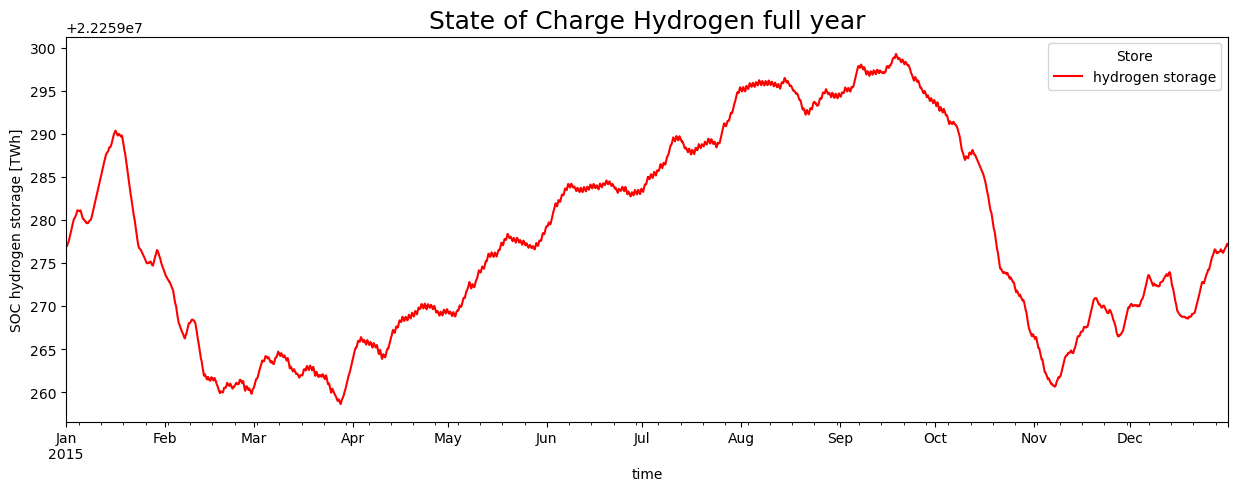

In [49]:
plt.figure(figsize =(15,5))
ax = plt.gca()
soc_hydrogen=(np.min(n_constrains.stores_t.p.cumsum(axis = 0),axis = 0) * -1-(n_constrains.stores_t.p/1e6).cumsum(axis = 0)) 
soc_hydrogen.plot(ax = ax, c ="red")
plt.ylabel("SOC hydrogen storage [TWh]")
plt.xlabel("time")
plt.title("State of Charge Hydrogen full year", fontsize = 18)

plt.figure(figsize =(15,5))
ax = plt.gca()
soc_hydrogen=((n_constrains.stores_t.p/1e6).cumsum(axis = 0) -  np.min(n_constrains.stores_t.p.cumsum(axis = 0),axis = 0) * 1) 
soc_hydrogen.plot(ax = ax, c ="red")
plt.ylabel("SOC hydrogen storage [TWh]")
plt.xlabel("time")
plt.title("State of Charge Hydrogen full year", fontsize = 18)

Text(0.5, 1.0, 'State of Charge Battery storage in July')

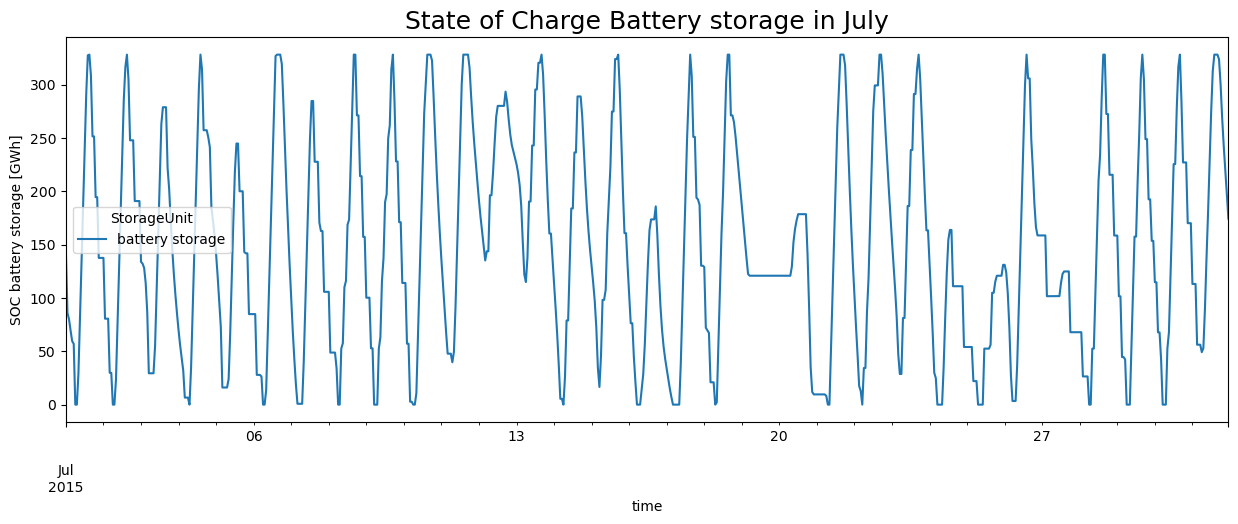

In [50]:
(n_constrains.storage_units_t.state_of_charge.loc[n_constrains.storage_units_t.state_of_charge.index.month==7]/1e3).plot(figsize =(15,5))
plt.ylabel("SOC battery storage [GWh]")
plt.xlabel("time")
plt.title("State of Charge Battery storage in July", fontsize = 18)

# (n.storage_units_t.state_of_charge.loc[n.storage_units_t.state_of_charge.index.month==7]/1e3).plot(figsize =(15,5))
# plt.ylabel("SOC battery storage [GWh]")
# plt.xlabel("time")
# plt.title("Base Model State of Charge Battery storage in July", fontsize = 18)

### (h) Plot the hydrogen production of the electrolysis and the hydrogen consumption of the fuel cells over time. Choose a figure size of 20 by 3 inches.

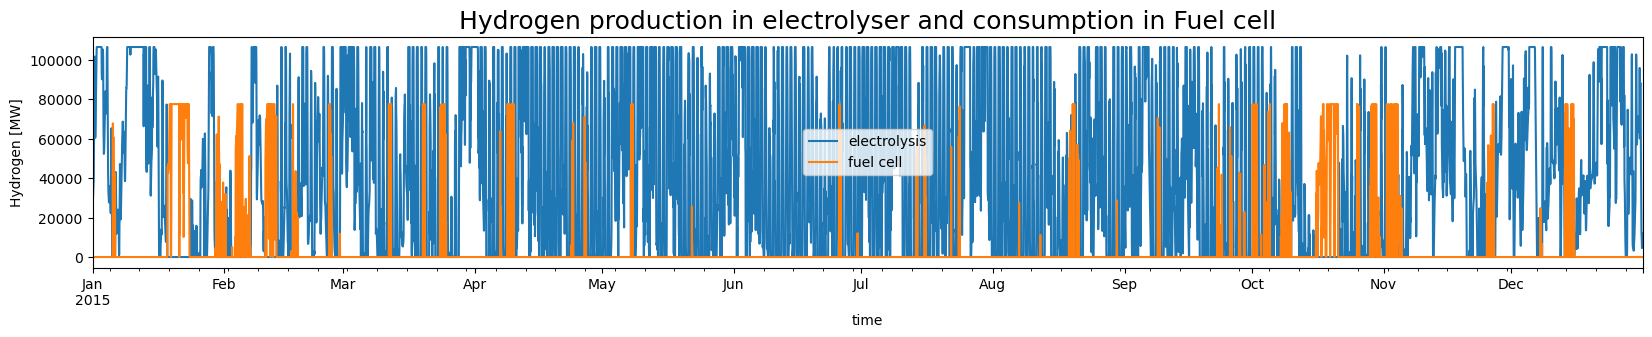

In [51]:
(n_constrains.links_t.p1.electrolysis*-1).plot(figsize=(20,3))
plt.title("Hydrogen production in electrolyser and consumption in Fuel cell",fontsize = 18)
plt.ylabel("Hydrogen [MW]")
plt.xlabel("time")
n_constrains.links_t.p0["fuel cell"].plot(figsize=(20,3))
#plt.title("Hydrogen consumption",fontsize = 18)
plt.ylabel("Hydrogen [MW]")
plt.xlabel("time")
plt.legend()

Text(0.5, 0, 'time')

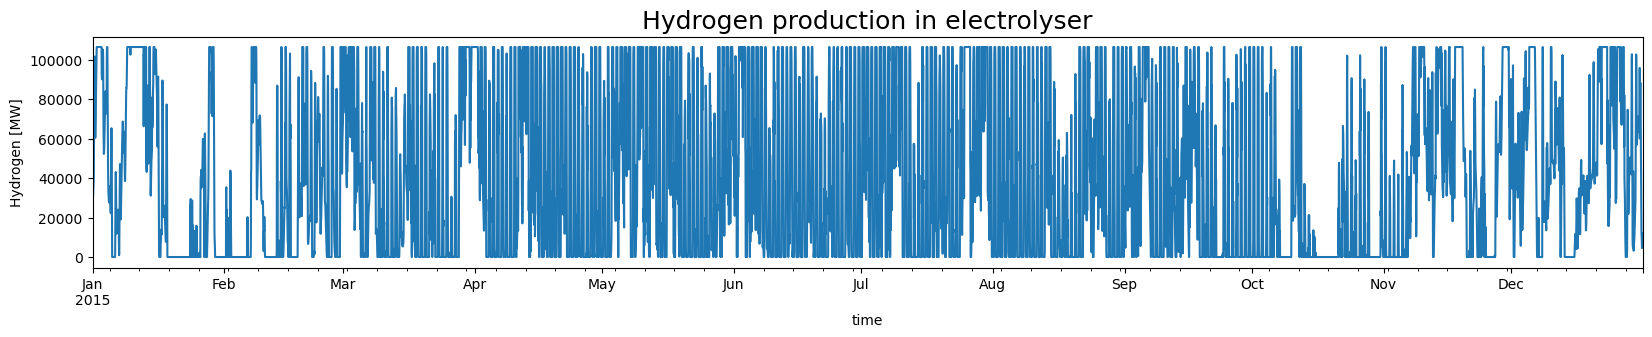

In [52]:
(n_constrains.links_t.p1.electrolysis*-1).plot(figsize=(20,3))
plt.title("Hydrogen production in electrolyser",fontsize = 18)
plt.ylabel("Hydrogen [MW]")
plt.xlabel("time")

Text(0.5, 0, 'time')

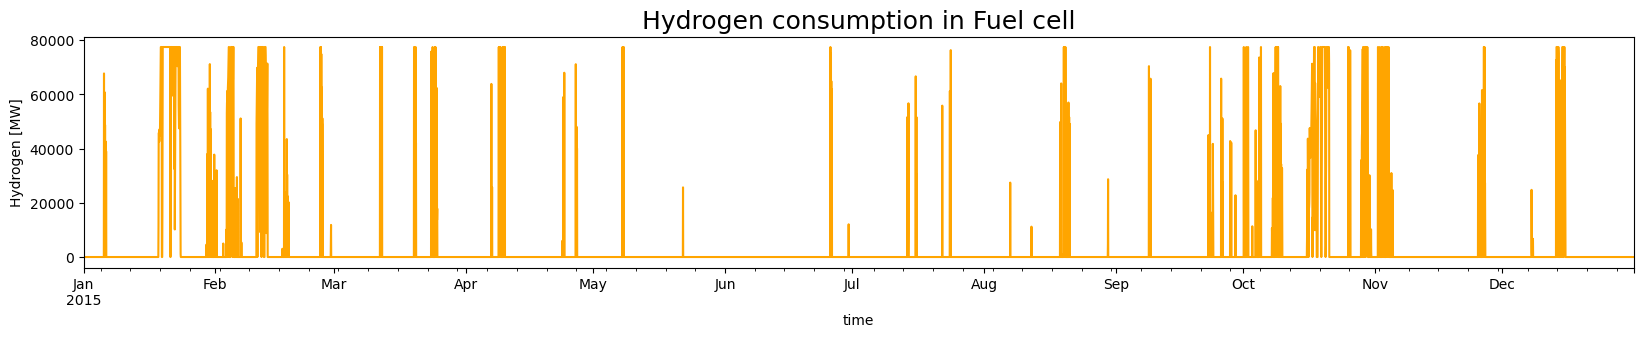

In [53]:
n_constrains.links_t.p0["fuel cell"].plot(figsize=(20,3),c='orange')
plt.title("Hydrogen consumption in Fuel cell",fontsize = 18)
plt.ylabel("Hydrogen [MW]")
plt.xlabel("time")

### (i) Determine the average utilisation rate (in % of installed capacity) of the electrolysis and the fuel cell. Also determine the monthly average utilisation rates. Describe when electrolysers and fuel cells are running and formulate a hypothesis what might be causing this behaviour.

In [54]:
n_constrains.statistics() # capacity factor in this table will give the answer

Capacity Factor  Capital Expenditure   
            carrier                                                  
Generator   offwind                  0.356023         1.106866e+10  \
            onwind                   0.188795         1.921718e+10   
            solar                    0.121465         1.947818e+10   
Link        electrolysis             0.397275         7.596748e+09   
            fuel cell                0.054719         9.294554e+09   
Load        -                             NaN                  NaN   
            hydrogen                      NaN                  NaN   
StorageUnit battery storage          0.256613         5.276282e+09   
Store       hydrogen storage         0.475122         5.684036e+09   

                              Curtailment  Installed Capacity   
            carrier                                             
Generator   offwind            487.841897                 0.0  \
            onwind            3352.287675                 0.0   
            solar              484.482710                 0.0   
Link        electrolysis              NaN                 0.0   
            fuel cell                 NaN                 0.0   
Load        -                         NaN                 NaN   
            hydrogen                  NaN                 NaN   
StorageUnit battery storage      0.000000                 0.0   
Store       hydrogen storage          NaN                 0.0   

                              Operational Expenditure  Optimal Capacity   
            carrier                                                       
Generator   offwind                        498.432710      7.000000e+04  \
            onwind                       50974.640748      2.000000e+05   
            solar                          508.699897      4.188054e+05   
Link        electrolysis                     0.000000      1.519350e+05   
            fuel cell                        0.000000      7.745461e+04   
Load        -                                     NaN               NaN   
            hydrogen                              NaN               NaN   
StorageUnit battery storage                  0.000000      5.471337e+04   
Store       hydrogen storage                 0.000000      4.060026e+07   

                                   Revenue        Supply    Withdrawal  
            carrier                                                     
Generator   offwind           1.900815e+06  24921.635500      0.000000  
            onwind            2.983959e+06  37758.993147      0.000000  
            solar             2.224045e+06  50869.989731      0.000000  
Link        electrolysis      8.672086e+05  42251.941080 -60359.915829  
            fuel cell         1.061022e+06   2119.121225  -4238.242450  
Load        -                 6.658944e+06      0.000000 -54736.991667  
            hydrogen          3.629284e+06      0.000000 -38013.698630  
StorageUnit battery storage   6.023153e+05   6733.672384  -7306.504491  
Store       hydrogen storage  6.488626e+05  20773.845026 -20773.845026

In [55]:
avg_electolysis = (n_constrains.links_t.p0.electrolysis.mean())/n_constrains.links.p_nom_opt.electrolysis*100
print('Average utilisation rate (in % of installed capacity) of the Electrolysis is:',round(avg_electolysis,2),'%')
avg_fuel_cell = (n_constrains.links_t.p0['fuel cell'].mean())/n_constrains.links.p_nom_opt['fuel cell']*100
print('Average utilisation rate (in % of installed capacity) of the Fuel cell is:',round(avg_fuel_cell,2),'%')

Average utilisation rate (in % of installed capacity) of the Electrolysis is: 39.73 %
Average utilisation rate (in % of installed capacity) of the Fuel cell is: 5.47 %


In [56]:
monthly_avg_electrolysis = ((n_constrains.links_t.p0.electrolysis).resample('M').mean().mean())/n_constrains.links.p_nom_opt.electrolysis*100
monthly_avg_fuel_cell = ((n_constrains.links_t.p0['fuel cell']).resample('M').mean().mean())/n_constrains.links.p_nom_opt['fuel cell']*100
print('Monthly Average utilisation rate (in % of installed capacity) of the Electrolysis is:',round(monthly_avg_electrolysis,2),'%')
print('Average utilisation rate (in % of installed capacity) of the Fuel cell is:',round(monthly_avg_fuel_cell,2),'%')

Monthly Average utilisation rate (in % of installed capacity) of the Electrolysis is: 39.64 %
Average utilisation rate (in % of installed capacity) of the Fuel cell is: 5.5 %


Electrolyser works when there is excess electricity after electricity demand. and Fuel cell works when the electricity prie is higher to produce back the eclectriciy. Also efficiency of the fuel cell is low.
In some time period it will have enough electricity to run at full capacity for Electrolyser.

### (j) Plot the price duration curves for electricity and hydrogen. Label all axes appropriately. For each carrier, determine the month with the lowest and highest prices reached?

Text(0.5, 1.0, 'Price duration curve - Base Model')

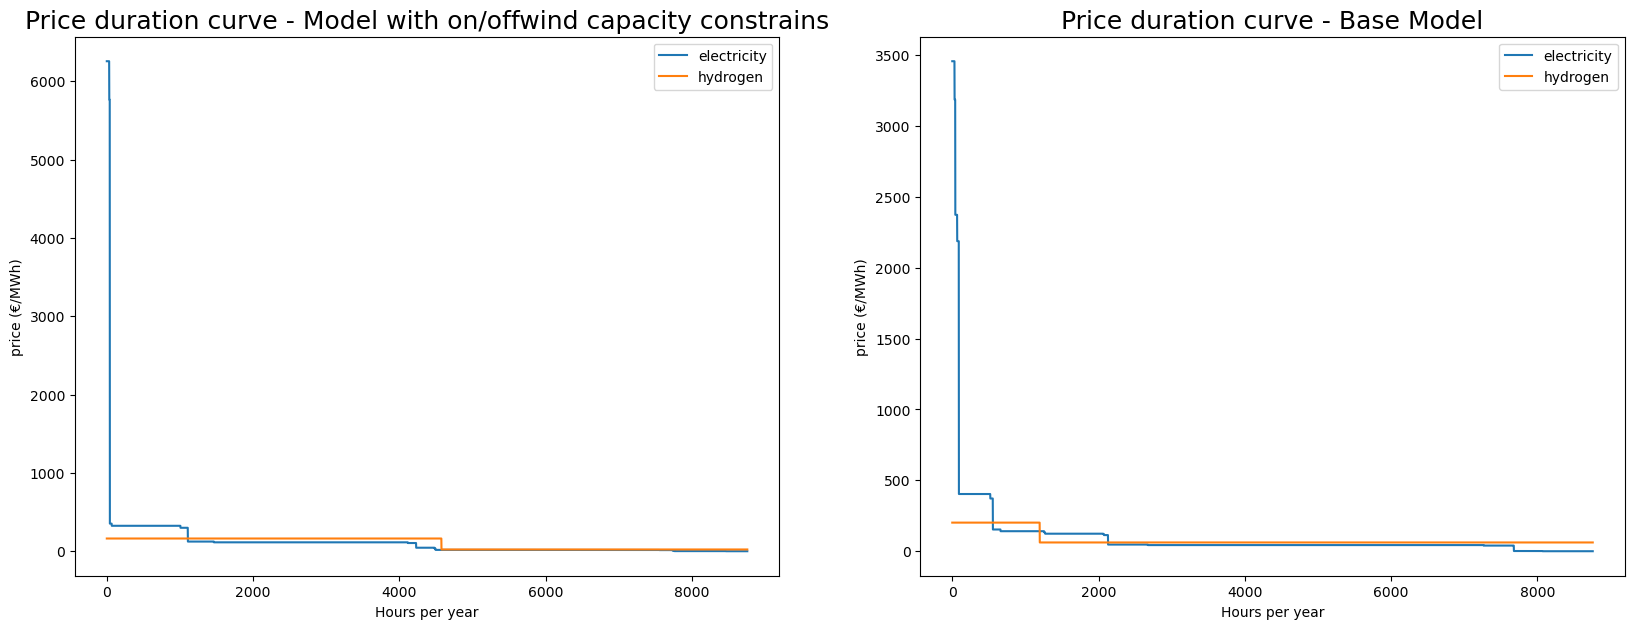

In [57]:
fig3, axes4 = plt.subplots(ncols=2,figsize=(20,7))
axes4,axes5 = axes4
pd.DataFrame(n_constrains.buses_t.marginal_price["electricity"]).sort_values("electricity",ascending=False).reset_index(drop=True).plot(ax=axes4, label = "Electricity")  
pd.DataFrame(n_constrains.buses_t.marginal_price["hydrogen"]).sort_values("hydrogen",ascending=False).reset_index(drop=True).plot(ax=axes4, label = "Hydrogen")
axes4.set_xlabel('Hours per year')
axes4.set_ylabel("price (€/MWh)")
#plt.legend()
axes4.set_title("Price duration curve - Model with on/offwind capacity constrains",fontsize=18)

pd.DataFrame(n.buses_t.marginal_price["electricity"]).sort_values("electricity",ascending=False).reset_index(drop=True).plot(ax=axes5, label = "Electricity")  
pd.DataFrame(n.buses_t.marginal_price["hydrogen"]).sort_values("hydrogen",ascending=False).reset_index(drop=True).plot(ax=axes5, label = "Hydrogen")
axes5.set_xlabel('Hours per year')
axes5.set_ylabel("price (€/MWh)")
#plt.legend()
axes5.set_title("Price duration curve - Base Model",fontsize=18)

Price for electricity reached highest on January and lowest on March to October.  
Price for Hydrogen reached highest on September to March and lowest on March to September

In [58]:
pd.DataFrame(n_constrains.buses_t.marginal_price).resample("M").max() # highest rate per month with constrains

Bus,electricity,hydrogen
snapshot,,
2015-01-31,6256.534382,162.340625
2015-02-28,324.681250,162.340625
2015-03-31,324.681250,162.340625
2015-04-30,44.681250,22.340625
2015-05-31,44.681250,22.340625
2015-06-30,44.681250,22.340625
2015-07-31,44.681250,22.340625
2015-08-31,44.681250,22.340625
2015-09-30,324.681250,162.340625


In [59]:
pd.DataFrame(n_constrains.buses_t.marginal_price).resample("M").min() # lowest rate per month with constrains

Bus,electricity,hydrogen
snapshot,,
2015-01-31,1.35,162.340625
2015-02-28,0.02,162.340625
2015-03-31,0.01,22.340625
2015-04-30,0.01,22.340625
2015-05-31,0.01,22.340625
2015-06-30,0.01,22.340625
2015-07-31,0.01,22.340625
2015-08-31,0.01,22.340625
2015-09-30,0.01,22.340625


### (k) Determine the demand-weighted average price of electricity and the demand-weighted average price of hydrogen. Which price is lower? Try to explain why.

In [60]:
demand_w_avg_electricity =((n_constrains.buses_t.marginal_price.electricity*n_constrains.loads_t.p.demand).sum())/n_constrains.loads_t.p.demand.sum()
print('Demand-Weighted avg price of electricity is',round(demand_w_avg_electricity,3),'€/MWh')
demand_w_avg_electricity

Demand-Weighted avg price of electricity is 121.653 €/MWh


121.65344858714211

In [61]:
demand_w_avg_hydrogen =((n_constrains.buses_t.marginal_price.hydrogen*n_constrains.loads_t.p["hydrogen demand"]).sum())/n_constrains.loads_t.p['hydrogen demand'].sum()
print('Demand-Weighted avg price of Hydrogen is',round(demand_w_avg_hydrogen,3),'€/MWh')
demand_w_avg_hydrogen

Demand-Weighted avg price of Hydrogen is 95.473 €/MWh


95.47304511903128

#### Demand-Weighted avg price of electricity is higher than that of the Hydrogen. Its because of the following reason  


hydrogen price is less due to less hydrogen demand compared to electricity demand and capital cost of electrolysis less than on wind and offwind. And no operational and maintenance cost

In [62]:
demand_w_avg_electricity =((n.buses_t.marginal_price.electricity*n.loads_t.p.demand).sum())/n.loads_t.p.demand.sum()
print('Demand-Weighted avg price of electricity is',round(demand_w_avg_electricity,3),'€/MWh (base model)')
demand_w_avg_hydrogen =((n.buses_t.marginal_price.hydrogen*n.loads_t.p.demand).sum())/n.loads_t.p['hydrogen demand'].sum()
print('Demand-Weighted avg price of Hydrogen is',round(demand_w_avg_hydrogen,3),'€/MWh (base model)')

Demand-Weighted avg price of electricity is 103.717 €/MWh (base model)
Demand-Weighted avg price of Hydrogen is 116.554 €/MWh (base model)


for base model, price is higher because major share of hydrogen production is by offwind, which has higher capital cost than onwind. In base model offwind capacity is almost double of onwind

### (l) Plot the power consumption of the electrolysis and the power injection of the fuel cell against the electricity price in a scatter plot. Limit the extent of the axis with the electricity prices to 500 €/MWh. At what prices do fuel cell and electrolysis tend to run?

In [63]:
x_e = n_constrains.links_t.p0.electrolysis # power cosumption for electrolysis
y_e = n_constrains.buses_t.marginal_price.electricity # electricity price

x_h = n_constrains.links_t.p1['fuel cell']*-1 # power injected by fuelcell
y_h = n_constrains.buses_t.marginal_price.electricity # electricity price

Text(0.5, 1.0, 'Fuel cell - Injection Vs price')

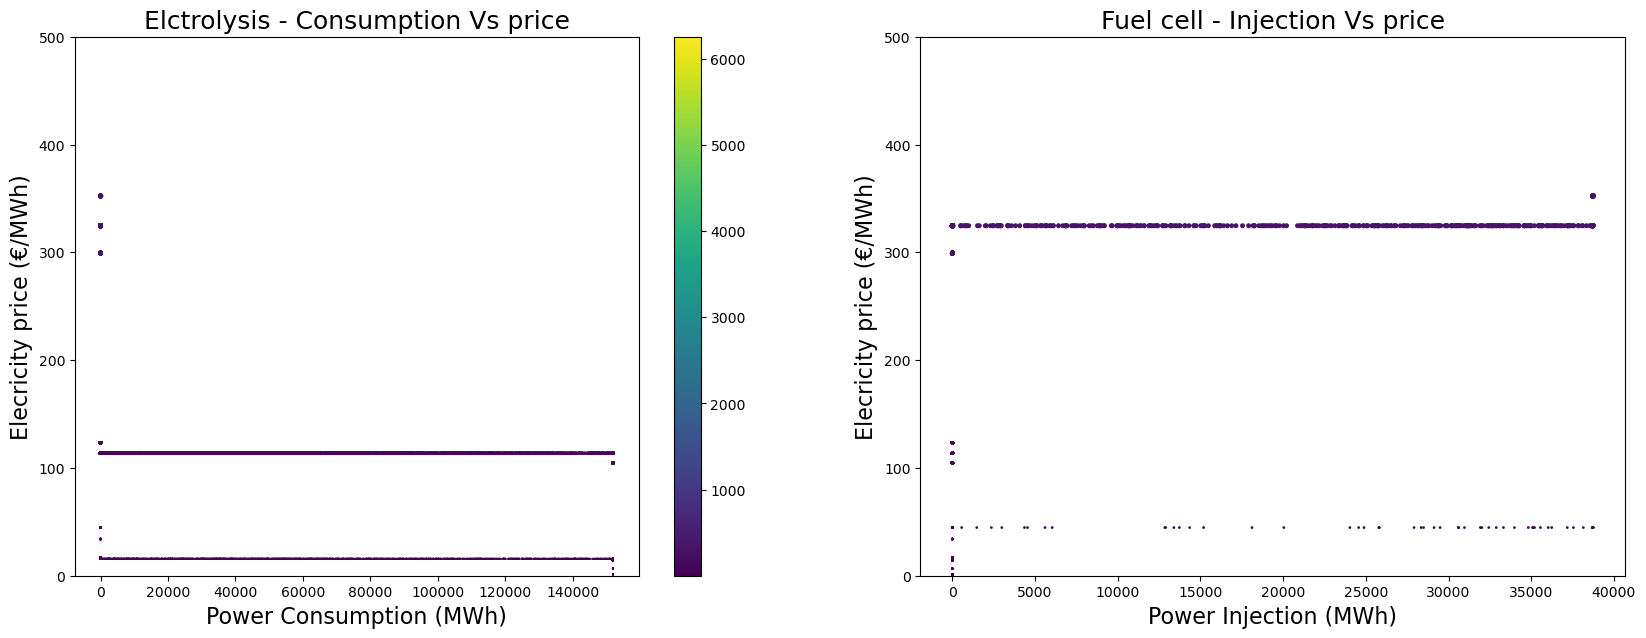

In [64]:
fig4,ax4 = plt.subplots(figsize = (20,7),ncols=2)
ax4_1,ax4_2 = ax4
ax4_1.set_ylim(0,500)
ax4_2.set_ylim(0,500)
#ax4_1.set_xlim(0,5000)
splot1=ax4_1.scatter(x_e,y_e,s=y_e/50,c = y_e,cmap='viridis')
fig4.colorbar(splot1)
ax4_1.set_xlabel('Power Consumption (MWh)',fontsize = 16)
ax4_1.set_ylabel('Elecricity price (€/MWh)',fontsize = 16)
ax4_1.set_title('Elctrolysis - Consumption Vs price',fontsize = 18)
ax4_2.scatter(x_h,y_h,s=y_h/50,c = y_e,cmap='viridis')
ax4_2.set_xlabel('Power Injection (MWh)',fontsize = 16)
ax4_2.set_ylabel('Elecricity price (€/MWh)',fontsize = 16)
ax4_2.set_title('Fuel cell - Injection Vs price',fontsize = 18)

In the above diagram when the electricity price above the second horizontal line fuel cell starts to work and when below electrolysis works.  

In [65]:
unique_elements, counts_elements = np.unique(y_e, return_counts=True) # code from google
price = unique_elements[np.argmax(counts_elements)]
print("The price line for the working of Fuel cell and Electrolyse is",round(price,2),"€/MWh")
price # euro/MWh

The price line for the working of Fuel cell and Electrolyse is 113.64 €/MWh


113.63843751939496

Above this price fuel cell works and below this electrolysis works if needed

Text(0, 0.5, 'Elecricity price (€/MWh)')

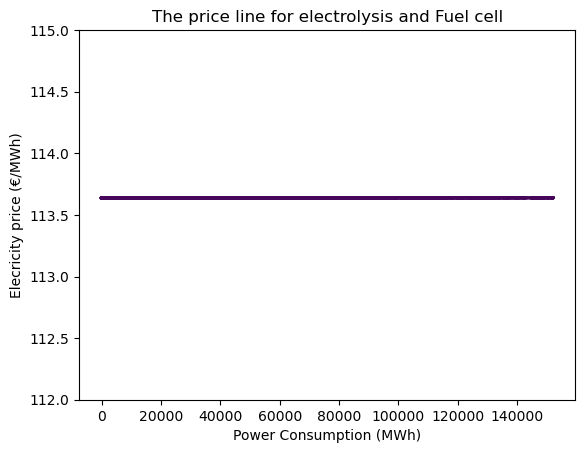

In [66]:
# This figure shows the line of working of Fuel cell and electrolysis (magnified plot)
fig,ax = plt.subplots()
ax.set_ylim(112,115)
ax.scatter(x_e,y_e,s=y_e/50,c = y_e,cmap='viridis')
ax.set_title("The price line for electrolysis and Fuel cell")
ax.set_xlabel('Power Consumption (MWh)')
ax.set_ylabel('Elecricity price (€/MWh)')

From the below graph we can see the injection of fuel cell is only taking place above that electricity price for the month February.

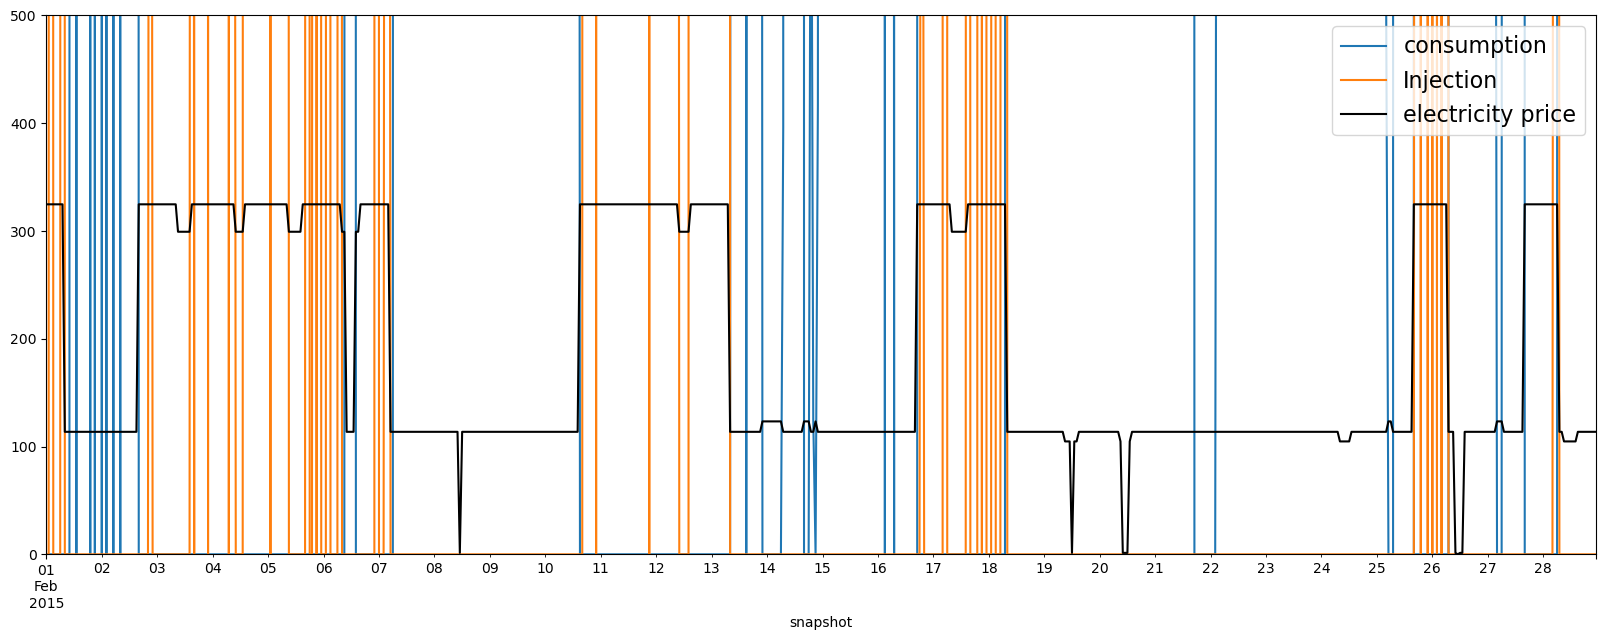

In [67]:
m = 2 # for the month February

x_e.loc[n_constrains.links_t.p0.electrolysis.index.month==m].plot(figsize = (20,7),label = 'consumption')
x_h.loc[(n_constrains.links_t.p1['fuel cell']*-1).index.month==m].plot(figsize = (20,7),label = 'Injection')
#y_h.loc[n_constrains.buses_t.marginal_price.electricity.index.month==2].plot(figsize = (20,7))
y_e.loc[n_constrains.buses_t.marginal_price.electricity.index.month==m].plot(figsize = (20,7),c='black',label = 'electricity price')
plt.ylim(0,500)
#plt.hlines(demand_w_avg_electricity,xmin =0,xmax =2000000,color='r',label = 'demand_w_avg_electricity')
plt.legend(fontsize = 16)

### (m) Name and describe three of the major limitations of the modelling above.

1). Hydrogen demand is constant.  
    We assumed constant hydrogen demand throughout the year.    
2). p_max_pu is infinitive for generators.    
    So here Generation is not according to wind/solar potential, but only according to demand.So the system will design optimal capacity in order to meet the demand.    
3). Only one bus for electricity and hydrogen, actualy it will differ. Hence it will affect the price.

In [68]:
n_constrains.statistics()

Capacity Factor  Capital Expenditure   
            carrier                                                  
Generator   offwind                  0.356023         1.106866e+10  \
            onwind                   0.188795         1.921718e+10   
            solar                    0.121465         1.947818e+10   
Link        electrolysis             0.397275         7.596748e+09   
            fuel cell                0.054719         9.294554e+09   
Load        -                             NaN                  NaN   
            hydrogen                      NaN                  NaN   
StorageUnit battery storage          0.256613         5.276282e+09   
Store       hydrogen storage         0.475122         5.684036e+09   

                              Curtailment  Installed Capacity   
            carrier                                             
Generator   offwind            487.841897                 0.0  \
            onwind            3352.287675                 0.0   
            solar              484.482710                 0.0   
Link        electrolysis              NaN                 0.0   
            fuel cell                 NaN                 0.0   
Load        -                         NaN                 NaN   
            hydrogen                  NaN                 NaN   
StorageUnit battery storage      0.000000                 0.0   
Store       hydrogen storage          NaN                 0.0   

                              Operational Expenditure  Optimal Capacity   
            carrier                                                       
Generator   offwind                        498.432710      7.000000e+04  \
            onwind                       50974.640748      2.000000e+05   
            solar                          508.699897      4.188054e+05   
Link        electrolysis                     0.000000      1.519350e+05   
            fuel cell                        0.000000      7.745461e+04   
Load        -                                     NaN               NaN   
            hydrogen                              NaN               NaN   
StorageUnit battery storage                  0.000000      5.471337e+04   
Store       hydrogen storage                 0.000000      4.060026e+07   

                                   Revenue        Supply    Withdrawal  
            carrier                                                     
Generator   offwind           1.900815e+06  24921.635500      0.000000  
            onwind            2.983959e+06  37758.993147      0.000000  
            solar             2.224045e+06  50869.989731      0.000000  
Link        electrolysis      8.672086e+05  42251.941080 -60359.915829  
            fuel cell         1.061022e+06   2119.121225  -4238.242450  
Load        -                 6.658944e+06      0.000000 -54736.991667  
            hydrogen          3.629284e+06      0.000000 -38013.698630  
StorageUnit battery storage   6.023153e+05   6733.672384  -7306.504491  
Store       hydrogen storage  6.488626e+05  20773.845026 -20773.845026

# Task 2: Hydrogen Imports

### (a) Build and solve a new PyPSA model for each of the potential exporting country according to the following scheme:
Use the same cost and technology assumptions as for the PyPSA network in Task 1, but take onshore wind and solar capacity factor time series from model.energy for the year 2011:

In [69]:
Algeria_file = 'https://model.energy/data/time-series-7302b235f1cf37e19e408c863c038290.csv'
Argentina_file = 'https://model.energy/data/time-series-91c3af7cc2178900eb8c7248d0aa12c5.csv'
Namibia_file = 'https://model.energy/data/time-series-57f7bbcb5c4821506de052e52d022b48.csv'

In [70]:
algeria = pd.read_csv(Algeria_file,index_col=0)
argentina = pd.read_csv(Argentina_file,index_col=0)
namibia = pd.read_csv(Namibia_file,index_col=0)

In [71]:
algeria.set_index(n_constrains.snapshots,inplace=True)# sets index according to network data
argentina.set_index(n_constrains.snapshots,inplace=True)
namibia.set_index(n_constrains.snapshots,inplace=True)

### Assumptions

. No electricity demand for the three countries.     
. No offwind generation    
. No Capacity constrains (generates electricity and the hydrogen according to the wind and solar potential)    
. No Fuel cell   

In [72]:
n_algeria = pypsa.Network('n_base.nc')

INFO:pypsa.io:Imported network n_base.nc has buses, carriers, generators, links, loads, storage_units, stores


In [73]:
def model(network,country):
    network.remove('Link', 'fuel cell')
    network.remove('Generator', 'offwind')
    network.remove("Load","demand")
    network.generators_t.p_max_pu.onwind = country.onwind # sets onwind capacity factor
    network.generators_t.p_max_pu.solar = country.solar # sets solar capacity factor
    network.lopf(solver_name='gurobi')
    return network

In [74]:
model(n_algeria,algeria)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.3s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-7unqdh6w.lp
Reading time = 0.35 seconds
obj: 157680 rows, 70086 columns, 302432 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 157680 rows, 70086 columns and 302432 nonzeros
Model fingerprint: 0x3d908126
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  Objective range  [1e-02, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+04, 4e+04]
Presolve removed 74248 rows and 12929 columns
Presolve time: 0.21s
Presolved: 83432 rows, 57157 columns, 215256 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 1.931e+05
 Factor NZ  : 1.191e+06 (roughly 70 MB of memory)
 Factor Ops : 1.763e

INFO:pypsa.linopf:Optimization successful. Objective value: 2.16e+10


PyPSA Network
Components:
 - Bus: 2
 - Carrier: 6
 - Generator: 2
 - Link: 1
 - Load: 1
 - StorageUnit: 1
 - Store: 1
 - SubNetwork: 2
Snapshots: 8760

In [75]:
n_argentina = pypsa.Network('n_base.nc')

INFO:pypsa.io:Imported network n_base.nc has buses, carriers, generators, links, loads, storage_units, stores


In [76]:
model(n_argentina,argentina)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-nta_4u4u.lp
Reading time = 0.35 seconds
obj: 157680 rows, 70086 columns, 302381 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 157680 rows, 70086 columns and 302381 nonzeros
Model fingerprint: 0x23421831
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  Objective range  [1e-02, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+04, 4e+04]
Presolve removed 74299 rows and 12980 columns
Presolve time: 0.22s
Presolved: 83381 rows, 57106 columns, 215103 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 1.930e+05
 Factor NZ  : 1.190e+06 (roughly 70 MB of memory)
 Factor Ops : 1.761e

INFO:pypsa.linopf:Optimization successful. Objective value: 1.87e+10


PyPSA Network
Components:
 - Bus: 2
 - Carrier: 6
 - Generator: 2
 - Link: 1
 - Load: 1
 - StorageUnit: 1
 - Store: 1
 - SubNetwork: 2
Snapshots: 8760

In [77]:
n_namibia = pypsa.Network('n_base.nc')

INFO:pypsa.io:Imported network n_base.nc has buses, carriers, generators, links, loads, storage_units, stores


In [78]:
model(n_namibia,namibia)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\bilwi\AppData\Local\Temp\pypsa-problem-actvt7fq.lp
Reading time = 0.35 seconds
obj: 157680 rows, 70086 columns, 302176 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 157680 rows, 70086 columns and 302176 nonzeros
Model fingerprint: 0x4b9da333
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  Objective range  [1e-02, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+04, 4e+04]
Presolve removed 74504 rows and 13185 columns
Presolve time: 0.22s
Presolved: 83176 rows, 56901 columns, 214488 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 1.926e+05
 Factor NZ  : 1.186e+06 (roughly 70 MB of memory)
 Factor Ops : 1.754e

INFO:pypsa.linopf:Optimization successful. Objective value: 2.32e+10


PyPSA Network
Components:
 - Bus: 2
 - Carrier: 6
 - Generator: 2
 - Link: 1
 - Load: 1
 - StorageUnit: 1
 - Store: 1
 - SubNetwork: 2
Snapshots: 8760

#### (b) Compare 
(i) the average hydrogen production cost (in €/MWh),   
(ii) the optimal capacities built of
all system components (in GW), and    
(iii) the average utilisation rate of the electrolysis (in %) for
each of the three candidate countries. Use a table to present your comparison and also explain
the key differences in written text.

##### (i) the average hydrogen production cost (in €/MWh)

In [79]:
# production cost = (capital cost + operational and maintenance cost)/total production

In [80]:
n_algeria.statistics()

Capacity Factor  Capital Expenditure   
            carrier                                                  
Generator   onwind                   0.303871         9.865676e+09  \
            solar                    0.197089         5.452337e+09   
Link        electrolysis             0.608119         4.465024e+09   
Load        hydrogen                      NaN                  NaN   
StorageUnit battery storage               NaN         0.000000e+00   
Store       hydrogen storage         0.547509         1.476755e+09   

                               Curtailment  Installed Capacity   
            carrier                                              
Generator   onwind            2.479972e+03                 0.0  \
            solar             7.743164e-12                 0.0   
Link        electrolysis               NaN                 0.0   
Load        hydrogen                   NaN                 NaN   
StorageUnit battery storage   0.000000e+00                 0.0   
Store       hydrogen storage           NaN                 0.0   

                              Operational Expenditure  Optimal Capacity   
            carrier                                                       
Generator   onwind                       42120.116895      1.026756e+05  \
            solar                          231.051972      1.172321e+05   
Link        electrolysis                     0.000000      8.930048e+04   
Load        hydrogen                              NaN               NaN   
StorageUnit battery storage                  0.000000      0.000000e+00   
Store       hydrogen storage                 0.000000      1.054825e+07   

                                   Revenue        Supply    Withdrawal  
            carrier                                                     
Generator   onwind            1.168339e+06  31200.086589      0.000000  
            solar             6.226440e+05  23105.197168      0.000000  
Link        electrolysis      5.097059e+05  38013.698630 -54305.283757  
Load        hydrogen          2.469268e+06      0.000000 -38013.698630  
StorageUnit battery storage   0.000000e+00      0.000000      0.000000  
Store       hydrogen storage  1.685794e+05   6995.974838  -6995.974838

In [81]:
def avg_h2_pc(network): # fuction to find avgerage hydrogen productioon cost
    Avg_hydrogen_pc = (network.statistics()["Capital Expenditure"].sum()+network.statistics()["Operational Expenditure"].sum())/(p_set_hydrogen*8760)
    return Avg_hydrogen_pc

In [82]:
alg = avg_h2_pc(n_algeria)
print("The average hydrogen production cost in Algeria is:",round(alg,2),"%")
arg = avg_h2_pc(n_argentina)
print("The average hydrogen production cost in Argentina is:",round(arg,2),"%")
nam = avg_h2_pc(n_namibia)
print("The average hydrogen production cost in Namibia is:",round(nam,2),"%")

The average hydrogen production cost in Algeria is: 63.84 %
The average hydrogen production cost in Argentina is: 54.35 %
The average hydrogen production cost in Namibia is: 69.77 %


In [83]:
Country = ['Algeria','Argentina','Namibia']
avg_h2_pc = pd.DataFrame({'Country':Country})
avg_h2_pc.loc[0,'avg_h2_production_cost(€/MWh)'] = alg
avg_h2_pc.loc[1,'avg_h2_production_cost(€/MWh)'] = arg
avg_h2_pc.loc[2,'avg_h2_production_cost(€/MWh)'] = nam
avg_h2_pc

,Country,avg_h2_production_cost(€/MWh)
0,Algeria,63.843348
1,Argentina,54.354194
2,Namibia,69.769293


p_c_a = n_algeria.buses_t.marginal_price.hydrogen.mean()
print('Average hydrogen production cost in Algeria is:',round(p_c_a,3),'(€/MWh)')

p_c_ar = n_argentina.buses_t.marginal_price.hydrogen.mean()
print('Average hydrogen production cost in Argentina is:',round(p_c_ar,3),'(€/MWh)')

p_c_n = n_namibia.buses_t.marginal_price.hydrogen.mean()
print('Average hydrogen production cost in Namibia is:',round(p_c_n,3),'(€/MWh)')

n_algeria.buses_t.marginal_price.hydrogen.plot(figsize = (15,5),label = 'Algeria')
n_argentina.buses_t.marginal_price.hydrogen.plot(figsize = (15,5),label = 'Argentina')
n_namibia.buses_t.marginal_price.hydrogen.plot(figsize = (15,5),label = 'Namibia')
plt.legend()
plt.title('Hydrogen Production Cost',fontsize=18)
plt.xlabel('Time')
plt.ylabel('€/MWh')

##### (ii) the optimal capacities built of all system components (in GW)

In [84]:
#n_algeria.statistics()

In [85]:
alg_pd = pd.DataFrame(n_algeria.statistics()['Optimal Capacity'].div(1e3)) # in GW

In [86]:
arg_pd = pd.DataFrame(n_argentina.statistics()['Optimal Capacity'].div(1e3)) # in GW

In [87]:
nam_pd = pd.DataFrame(n_namibia.statistics()['Optimal Capacity'].div(1e3)) # in GW

In [88]:
Optimal_Capacity_df = pd.concat([alg_pd,arg_pd,nam_pd], axis=1)
Optimal_Capacity_df.columns = ['Algeria Optimal Capacity','Argentina Optimal Capacity','Namibia Optimal Capacity']
Optimal_Capacity_df

Algeria Optimal Capacity   
            carrier                                      
Generator   onwind                          102.675601  \
            solar                           117.232142   
Link        electrolysis                     89.300479   
Load        hydrogen                               NaN   
StorageUnit battery storage                   0.000000   
Store       hydrogen storage              10548.252686   

                              Argentina Optimal Capacity   
            carrier                                        
Generator   onwind                            130.250750  \
            solar                              21.509298   
Link        electrolysis                       76.587441   
Load        hydrogen                                 NaN   
StorageUnit battery storage                     0.000000   
Store       hydrogen storage                 5391.956576   

                              Namibia Optimal Capacity  
            carrier                                     
Generator   onwind                            0.000000  
            solar                           300.536986  
Link        electrolysis                    160.787288  
Load        hydrogen                               NaN  
StorageUnit battery storage                   0.000000  
Store       hydrogen storage               8686.908492

In [91]:
# function to plot optimal capacity
def opt_capacity(network,country):
    fig, ax = plt.subplots(ncols= 2,figsize = (20,10))
    ax1,ax2 = ax
    (network.statistics()['Optimal Capacity'].div(1e3)).plot.bar(ax = ax1)
    (network.statistics()['Optimal Capacity'].div(1e3)).plot.pie(fontsize=16,ax=ax2,autopct='%1.1f%%',explode =[0.5,0.5,0.5,0.5,0.5,0])
    
    ax1.set_ylim(0,700) # limited because other capacities are too small to identify
    
    ax1_title = f'{country} Optimal capacity-Bar plot'
    ax2_title = f'{country} Optimal capacity-Pie plot'
    ax1.set_title(ax1_title,fontsize=18)
    ax2.set_title(ax2_title,fontsize = 18)
    ax1.set_xlabel('Carrier',fontsize = 14)
    ax1.set_ylabel('Capacity GW',fontsize = 14)
    return

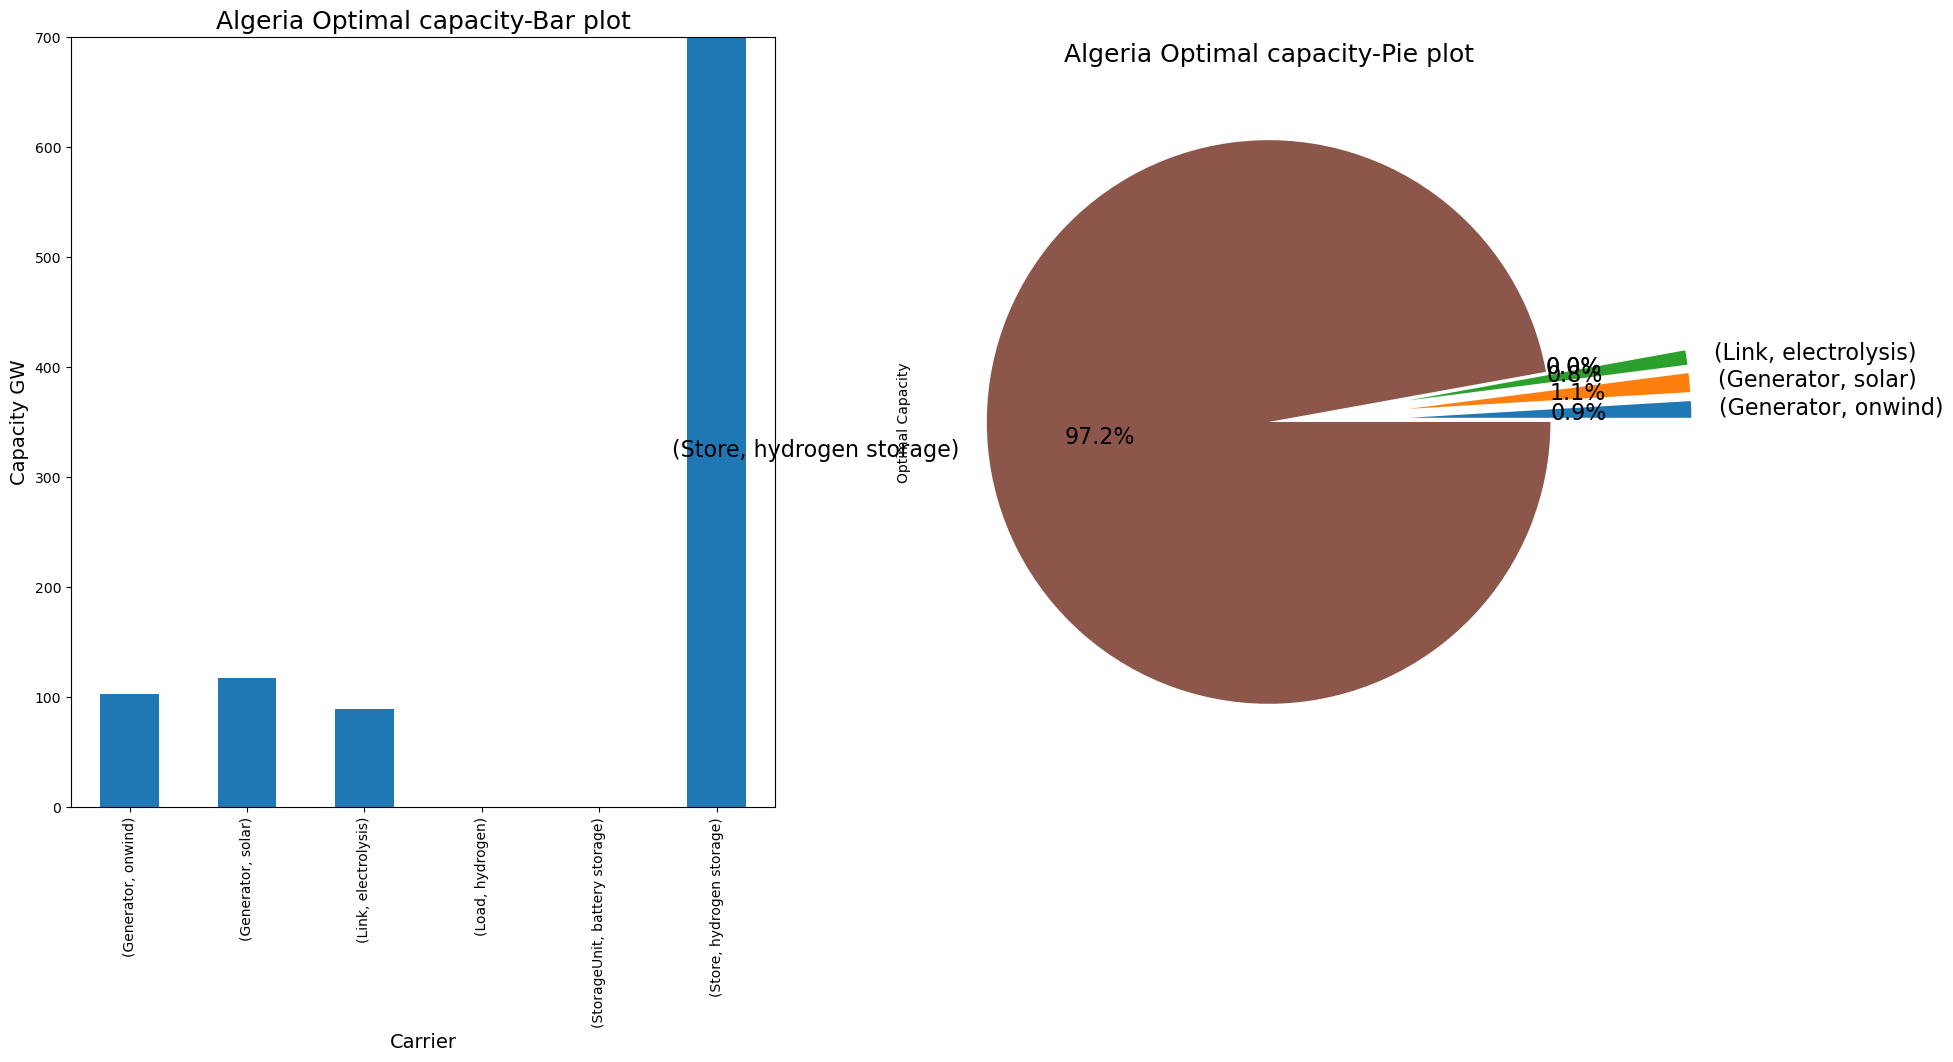

In [93]:
opt_capacity(n_algeria,'Algeria')

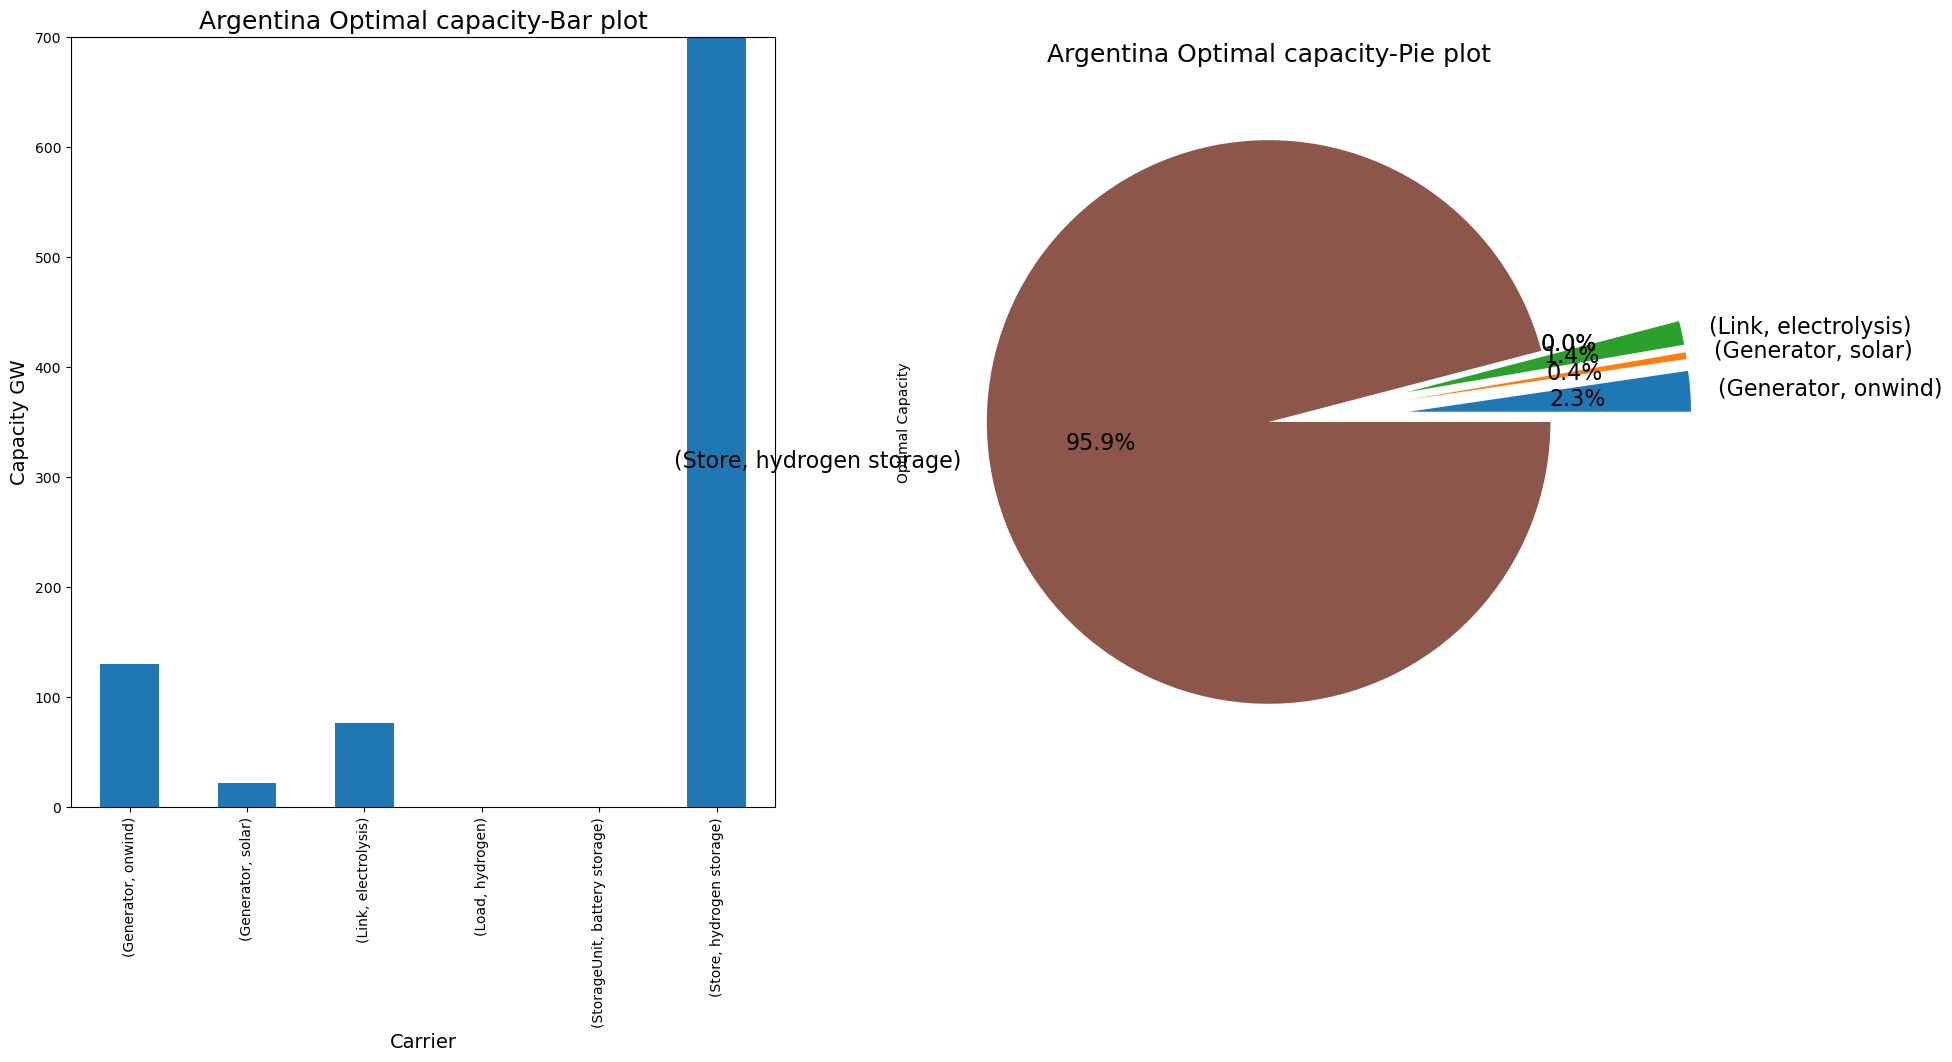

In [94]:
opt_capacity(n_argentina,'Argentina')

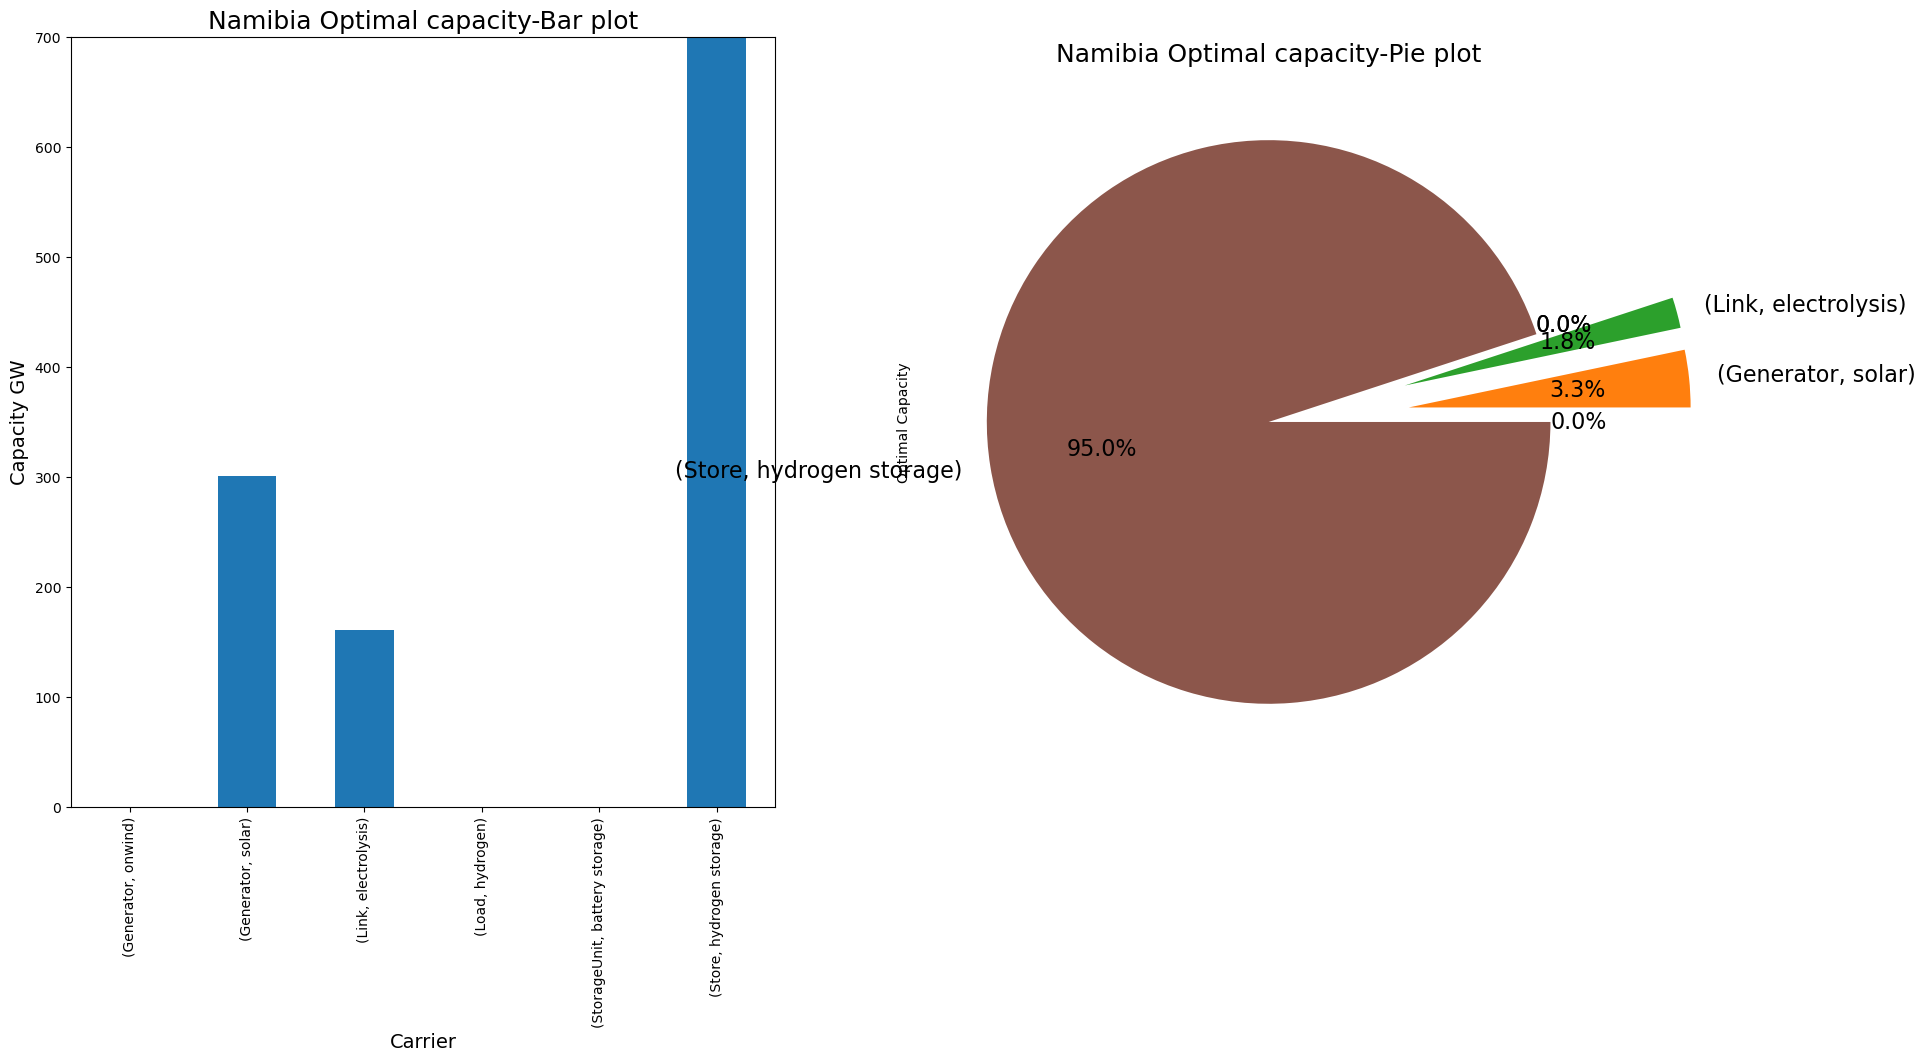

In [95]:
opt_capacity(n_namibia,'Namibia')

##### (iii) the average utilisation rate of the electrolysis (in %) for each of the three candidate countries. Use a table to present your comparison and also explain the key differences in written text.

In [96]:
def uti(network,country): # function which shows how much electrcity utilised for electrolysis compared to 
    # optimal capacity
    opt_capa = network.links.p_nom_opt.electrolysis # Average of total electricity
    #generation from onwind and solar
    ele = (network.links_t.p0.electrolysis).mean()
    avg_utilisation_rate_electrolysis = ele/opt_capa*100
    print('Average electricity utilisation rate of electrolysis in',country, 'is (in %):',round(avg_utilisation_rate_electrolysis,2),'%')

In [97]:
uti(n_algeria,'Algeria')

Average electricity utilisation rate of electrolysis in Algeria is (in %): 60.81 %


In [98]:
uti(n_argentina,'Argentina')

Average electricity utilisation rate of electrolysis in Argentina is (in %): 70.91 %


In [99]:
uti(n_namibia,'Namibia')

Average electricity utilisation rate of electrolysis in Namibia is (in %): 33.77 %


In [100]:
electrolysis_df = pd.DataFrame(n_algeria.links_t.p0).copy()

In [101]:
electrolysis_df.rename(columns={'electrolysis': 'Algeria_utilised'},inplace = True)
electrolysis_df['Algeria_uti_rate(%)'] = round(electrolysis_df['Algeria_utilised']*100/(n_algeria.links.p_nom_opt.electrolysis),2)
electrolysis_df['Argentina_utilised'] = n_argentina.links_t.p0
electrolysis_df['Argentina_uti_rate(%)'] = round(electrolysis_df['Argentina_utilised']*100/(n_argentina.links.p_nom_opt.electrolysis),2)
electrolysis_df['Namibia_utilised'] = n_namibia.links_t.p0
electrolysis_df['Namibia_uti_rate(%)'] = round(electrolysis_df['Namibia_utilised']*100/(n_namibia.links.p_nom_opt.electrolysis),2)

In [102]:
electrolysis_df.head(10)

Link,Algeria_utilised,Algeria_uti_rate(%),Argentina_utilised,Argentina_uti_rate(%),Namibia_utilised,Namibia_uti_rate(%)
snapshot,,,,,,
2015-01-01 00:00:00,10986.289293,12.30,37337.751803,48.75,0.000000,0.00
2015-01-01 01:00:00,10780.938091,12.07,38554.222114,50.34,0.000000,0.00
2015-01-01 02:00:00,11294.316095,12.65,37381.965361,48.81,0.000000,0.00
2015-01-01 03:00:00,12629.098907,14.14,34125.696601,44.56,0.000000,0.00
2015-01-01 04:00:00,13450.503713,15.06,30739.177091,40.14,0.000000,0.00
2015-01-01 05:00:00,14785.286525,16.56,27092.156080,35.37,1803.221919,1.12
2015-01-01 06:00:00,15812.042533,17.71,24096.388821,31.46,23742.421933,14.77
2015-01-01 07:00:00,17996.563419,20.15,21751.875314,28.40,64014.378122,39.81
2015-01-01 08:00:00,32195.429296,36.05,19928.364809,26.02,98275.594582,61.12


In [103]:
electrolysis_df.describe()

Link,Algeria_utilised,Algeria_uti_rate(%),Argentina_utilised,Argentina_uti_rate(%),Namibia_utilised,Namibia_uti_rate(%)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,54305.283757,60.811845,54305.283757,70.906324,54305.283757,33.774599
std,23380.552319,26.181912,17427.896336,22.755550,67344.359406,41.884111
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35936.460303,40.240000,41032.571255,53.577500,0.000000,0.000000
50%,50516.395626,56.570000,55458.738081,72.410000,0.000000,0.000000
75%,76121.351038,85.245000,70321.364417,91.820000,128028.756245,79.630000
max,89300.479240,100.000000,76587.441227,100.000000,160787.287772,100.000000


Argentina utiliced Electrolysis the most among others. And the Namibia utilised less. In case of Nigeria there is no electricity generation through onwind may be due to high solar potential and less capital cost for solar. In all three countries Electolysis meats its capacity(100 % utilisation) at some intervels and some times zero utilisation.

### (c) Which of the three candidate countries offers the lowest import costs to Germany when transport costs are taken into account? At what price? By what margin?
𝑇 (𝑑) = 30 + 0.001𝑑

In [104]:
# distance dataframe
data = {'Country':['algeria','argentina','namibia'],'See route distance (km)':[3500,13000,10000]}
distance = pd.DataFrame(data)

In [105]:
imp_cost = pd.concat([distance,avg_h2_pc['avg_h2_production_cost(€/MWh)']],axis=1)
mc_al = n_algeria.buses_t.marginal_price.hydrogen.mean()
mc_arg = n_argentina.buses_t.marginal_price.hydrogen.mean()
mc_nam = n_namibia.buses_t.marginal_price.hydrogen.mean()
imp_cost['avg_h2_marginal_cost(€/MWh)'] = [mc_al,mc_arg,mc_nam]

In [106]:
# function to calculate transportation cost.
def transport_cost(d):
    cost = 30+(0.001*d)
    return cost

In [107]:
imp_cost['H2 Transport cost (€/MWh)'] = imp_cost['See route distance (km)'].apply(transport_cost)
imp_cost['avg H2 Import cost (€/MWh)'] = imp_cost['avg_h2_marginal_cost(€/MWh)']+imp_cost['H2 Transport cost (€/MWh)']
imp_cost.set_index('Country',inplace=True)
imp_cost

,See route distance (km),avg_h2_production_cost(€/MWh),avg_h2_marginal_cost(€/MWh),H2 Transport cost (€/MWh),avg H2 Import cost (€/MWh)
Country,,,,,
algeria,3500,63.843348,64.957324,33.5,98.457324
argentina,13000,54.354194,56.144304,43.0,99.144304
namibia,10000,69.769293,69.783577,40.0,109.783577


In [108]:
print('Algeria offer lowest import cost for hydrogen and it is',round(imp_cost['avg H2 Import cost (€/MWh)'].min(),2),'€/MWh')

Algeria offer lowest import cost for hydrogen and it is 98.46 €/MWh


#### Algeria offer lowest import cost for hydrogen and it is 98.46 €/MWh. at amargin of 0.69 €/Mwh less than argentina and 11.33 €/MWh less than Namibia

In [109]:
# margin with argentina
imp_cost.loc['argentina','avg H2 Import cost (€/MWh)']-imp_cost.loc['algeria','avg H2 Import cost (€/MWh)']

0.6869797822152606

In [110]:
# margin with Namibia
imp_cost.loc['namibia','avg H2 Import cost (€/MWh)']-imp_cost.loc['algeria','avg H2 Import cost (€/MWh)']

11.326252683480433

### (d) Name and describe two limitations of the modelling above you can think of.

### 1). 
#### In this analysis there is no energy consumption among the candidate countries. If there is demand they have to first think of their on demand (hydrogen and electricity). And then excess hydrogen will be transported. That we are not sure about a single country can cover the 330 TWh hydrogen import demand of Germany. Also when we consider the electricity demands the price will also change.

### 2).
#### This analysis gives average hydrogen import cost. And the difference between import cost from Algeria and Argentina 0.69 €/MWh. This is not a huge difference. And from the below plot its clear that the price varies with time. So the hydrogen import should be like import hydrogen when the price is low and store it . If we follow this we can import the hydrogen from all three countries with price below 40 €/MWh. But system cost will increase.
#### For that we have to create a big network containing Germany and other three countries and we have done following.    
.) Double the Germany hydrogen demand (that means 330 TWh generation + 330 TWh import).   
.) Set a limit so that Germany only produces 330 TWh of Hydrogen (that means Generation within the country).    
.) And import rest of the 330 TWh (import target) from three countries by providing a one directional link. By connecting Hydogen buse from the three countries to the hydrogen bus of Germany.
#### Here we are only considering single bus for each country(for hydrogen) but actual case there will be more buses and there will be distance between buses this will further increase the transportation cost. 

Text(0, 0.5, '€/MWh')

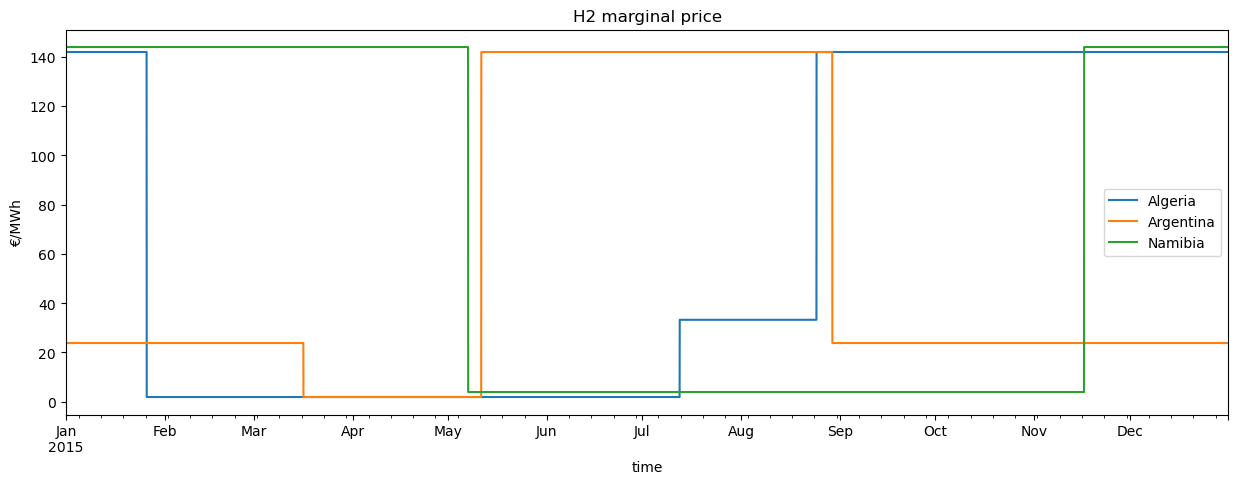

In [111]:
n_algeria.buses_t.marginal_price.hydrogen.plot(figsize=(15,5),label='Algeria')
n_argentina.buses_t.marginal_price.hydrogen.plot(figsize=(15,5),label='Argentina')
n_namibia.buses_t.marginal_price.hydrogen.plot(figsize=(15,5),label='Namibia')
plt.legend()
plt.title('H2 marginal price')
plt.xlabel('time')
plt.ylabel('€/MWh')

In [112]:
n_algeria.buses_t.marginal_price.hydrogen.describe()

count    8760.000000
mean       64.957324
std        66.716647
min         1.928571
25%         1.928571
50%        33.268895
75%       141.928571
max       141.928571
Name: hydrogen, dtype: float64

In [113]:
n_argentina.buses_t.marginal_price.hydrogen.describe()

count    8760.000000
mean       56.144304
std        56.927838
min         1.928571
25%        23.840575
50%        23.840575
75%       141.928571
max       141.928571
Name: hydrogen, dtype: float64

In [114]:
n_namibia.buses_t.marginal_price.hydrogen.describe()

count    8760.000000
mean       69.783577
std        69.879598
min         3.954810
25%         3.954810
50%         3.954810
75%       143.954810
max       143.954810
Name: hydrogen, dtype: float64